# CGAN Federada
Esse notebook tem por objetivo avaliar o treinamento de uma CGAN em um cenário federado heterogêneo. Para isso, vamos treinar a CGAN, simulando um cenário federado com dados dos clientes provindos de uma distribuição de Diirichlet com parâmetro *alpha* 0.1 e utilizando o método F2U [Yonetani, 2019](https://arxiv.org/abs/1905.09684). Após treinada, vamos gerar dados com a CGAN e depois treinar um modelo classificador em cima do banco de dados CIFAR-10, reportando a acurácia e comparando com o treinamento nos dados reais.

Antes de mais nada, vou preparar o nb para salvar logs de treinamento.

In [1]:
# --- Detectar Ambiente (Colab ou Local) ---
IN_COLAB = False
try:
    # Tenta importar um módulo específico do Colab
    from google.colab import drive
    import shutil # Usaremos para copiar, se necessário, mas salvar direto é melhor
    import os

    try:
        drive.mount('/content/drive')
        # Crie um diretório específico para salvar os resultados desta execução
        save_base_dir = "/content/drive/MyDrive/GAN_Training_Results" # Ajuste o caminho como desejar
        os.makedirs(save_base_dir, exist_ok=True)
        # Opcional: Crie um subdiretório único para esta execução específica (ex: baseado em timestamp)
        # import datetime
        # timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        # save_dir = os.path.join(save_base_dir, f"run_{timestamp}")
        # os.makedirs(save_dir, exist_ok=True)
        # Por simplicidade, vamos usar o diretório base diretamente por enquanto
        save_dir = save_base_dir
        print(f"✅ Google Drive montado. Arquivos serão salvos em: {save_dir}")
    except Exception as e:
        print(f"⚠️ Erro ao montar o Google Drive: {e}")
        print("   Downloads diretos serão tentados, mas podem atrasar.")
        save_dir = "." # Salvar localmente se o Drive falhar
    IN_COLAB = True
    print("✅ Ambiente Google Colab detectado. Downloads automáticos (a cada 2 épocas) ativados.")
except ImportError:
    print("✅ Ambiente local detectado. Downloads automáticos desativados.")

import os

✅ Ambiente local detectado. Downloads automáticos desativados.


In [2]:
import torch

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Modelo classificador
Vou definir aqui o modelo classificador, como o foco não é a criação de um novo modelo, escolhi um simples no treinamento do [Pytorch](https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

In [94]:
import torch.nn as nn
import torch.nn.functional as F

In [95]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Modelo Generativo

In [4]:
import numpy as np
import torch
import torch.nn as nn

In [5]:
class F2U_GAN_CIFAR(nn.Module):
    def __init__(self, img_size=32, latent_dim=128, condition=True):
        super(F2U_GAN_CIFAR, self).__init__()
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.classes = 10
        self.channels = 3
        self.condition = condition

        # Embedding para condicionamento
        self.label_embedding = nn.Embedding(self.classes, self.classes) if self.condition else None

        # Shapes de entrada
        self.input_shape_gen = self.latent_dim + (self.classes if self.condition else 0)
        self.input_shape_disc = self.channels + (self.classes if self.condition else 0)

        # -----------------
        #  Generator
        # -----------------
        self.generator = nn.Sequential(
            nn.Linear(self.input_shape_gen, 512 * 4 * 4),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (512, 4, 4)),                  # → (512,4,4)

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # → (256,8,8)
            nn.BatchNorm2d(256, momentum=0.1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # → (128,16,16)
            nn.BatchNorm2d(128, momentum=0.1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128,  64, kernel_size=4, stride=2, padding=1),  # → ( 64,32,32)
            nn.BatchNorm2d(64,  momentum=0.1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d( 64,   self.channels, kernel_size=3, stride=1, padding=1),  # → (3,32,32)
            nn.Tanh()
        )

        # -----------------
        #  Discriminator
        # -----------------
        layers = []
        in_ch = self.input_shape_disc
        cfg = [
            ( 64, 3, 1),  # → spatial stays 32
            ( 64, 4, 2),  # → 16
            (128, 3, 1),  # → 16
            (128, 4, 2),  # → 8
            (256, 4, 2),  # → 4
        ]
        for out_ch, k, s in cfg:
            layers += [
                nn.utils.spectral_norm(
                    nn.Conv2d(in_ch, out_ch, kernel_size=k, stride=s, padding=1)
                ),
                nn.LeakyReLU(0.1, inplace=True)
            ]
            in_ch = out_ch

        layers += [
            nn.Flatten(),
            nn.utils.spectral_norm(
                nn.Linear(256 * 4 * 4, 1)
            )
        ]
        self.discriminator = nn.Sequential(*layers)

        # adversarial loss
        self.adv_loss = nn.BCEWithLogitsLoss()

    def forward(self, input, labels=None):
        # Generator pass
        if input.dim() == 2 and input.size(1) == self.latent_dim:
            if self.condition:
                if labels is None:
                    raise ValueError("Labels must be provided for conditional generation")
                embedded = self.label_embedding(labels)
                gen_input = torch.cat((input, embedded), dim=1)
            else:
                gen_input = input
            img = self.generator(gen_input)
            return img

        # Discriminator pass
        elif input.dim() == 4 and input.size(1) == self.channels:
            x = input
            if self.condition:
                if labels is None:
                    raise ValueError("Labels must be provided for conditional discrimination")
                embedded = self.label_embedding(labels)
                # criar mapa de labels e concatenar
                lbl_map = embedded.view(-1, self.classes, 1, 1).expand(-1, self.classes, self.img_size, self.img_size)
                x = torch.cat((x, lbl_map), dim=1)
            return self.discriminator(x)

        else:
            raise ValueError("Input shape not recognized")

    def loss(self, logits, targets):
        return self.adv_loss(logits.view(-1), targets.float().view(-1))


In [177]:
##Verificacao de tamamhos das entradas da disc.
# dummy_input = torch.randn(1, model.input_shape_disc, model.img_size, model.img_size)
# x = dummy_input.to(device)
# print("Input discriminador: ", x.shape)
# for idx, layer in enumerate(model.discriminator):
#     x = layer(x)
#     print(f"Camada {idx:02d} ({layer.__class__.__name__}):", x.shape)

## Funções de treino e teste

### Classificador

In [101]:
import copy

In [102]:
def train_classifier(net, mode, optimizer, data_type, trainloader, epochs, agg="fedavg", criterion= nn.CrossEntropyLoss(), mu=0.5):
  net.to(device)
  global_params = copy.deepcopy(net).parameters()
  for epoch in range(epochs):  # loop over the dataset multiple times
      net.train()
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          if data_type == "syn" or mode == "fed":
            inputs, labels = data["img"].to(device), data["label"].to(device)
          else:
            inputs, labels = data[0].to(device), data[1].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          if agg == "fedprox":
            proximal_term = 0
            for local_weights, global_weights in zip(net.parameters(), global_params):
                proximal_term += (local_weights - global_weights).norm(2)
            loss = criterion(net(inputs), labels) + (mu / 2) * proximal_term
          else:
            loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()

      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(trainloader):.3f}')

  print('Finished Training')

In [104]:
def eval_classifier(net, testloader, mode: str = "cent"):
    # 2. Set eval mode
    net.to(device)
    net.eval()

    correct = 0
    total = 0

    # 3. Disable gradient computation
    with torch.no_grad():
        for data in testloader:
          if mode == "fed":
            images, labels = data["img"].to(device), data["label"].to(device)
          else:
            images, labels = data[0].to(device), data[1].to(device)

          # 5. Forward pass
          outputs = net(images)
          _, predicted = torch.max(outputs, 1)

          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total

    return accuracy

### Generativo

In [6]:
from tqdm.notebook import tqdm
import time

In [75]:
def train_gan(model, optimizer_D, optimizer_G, trainloader, epochs, e_to_save, mode_for_filename, batch_size=64, client=None, mu=0.5):
  historico_metricas = []
  filename = f"Treino_CGAN_CIFAR_{mode_for_filename}.txt"
  global_gen_params = [p.detach().clone() for p in model.generator.parameters()]
  global_disc_params = [p.detach().clone() for p in model.discriminator.parameters()]
  if IN_COLAB:
      filename = os.path.join(save_dir, filename)
  initial_time = time.time()
  for epoch in range(epochs):
      model.train()
      D_epoch_loss = 0.0
      G_epoch_loss = 0.0

      start_time = time.time()
      for data in tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
          if mode_for_filename.startswith("fed"):
            real_images, labels = data["img"].to(device), data["label"].to(device)
          else:
            real_images, labels = data[0].to(device), data[1].to(device)
          batch_size = real_images.size(0)

          # gera rótulos e ruído
          fake_labels = torch.randint(0, model.classes, (batch_size,), device=device)
          z = torch.randn(batch_size, model.latent_dim, device=device)

          # -----------------
          #  Atualiza Discriminador
          # -----------------
          optimizer_D.zero_grad()
          # real
          real_logits = model(real_images, labels)
          real_targets = torch.full((batch_size, 1), 1.0, device=device)
          loss_real = model.loss(real_logits, real_targets)
          # fake
          fake_images = model(z, fake_labels)
          fake_logits = model(fake_images.detach(), fake_labels)
          fake_targets = torch.full((batch_size, 1), 0.0, device=device)
          loss_fake = model.loss(fake_logits, fake_targets)
          # soma e passo
          loss_D = (loss_real + loss_fake) / 2
          if mode_for_filename.startswith("fedprox"):
            proximal_term = 0
            for local_weights, global_weights in zip(model.discriminator.parameters(), global_disc_params):
              diff = local_weights - global_weights.to(local_weights.device)
              proximal_term += diff.norm(2) ** 2
            loss_D = loss_D + (mu / 2) * proximal_term
          loss_D.backward()
          optimizer_D.step()

          # -----------------
          #  Atualiza Gerador
          # -----------------
          optimizer_G.zero_grad()
          fake_logits_for_G = model(fake_images, fake_labels)
          # usar mesmos real_targets para geração
          loss_G = model.loss(fake_logits_for_G, real_targets)
          if mode_for_filename.startswith("fedprox"):
            proximal_term = 0
            for local_weights, global_weights in zip(model.generator.parameters(), global_gen_params):
              diff = local_weights - global_weights.to(local_weights.device)
              proximal_term += diff.norm(2) ** 2
            loss_G = loss_G + (mu / 2) * proximal_term
          loss_G.backward()
          optimizer_G.step()

          D_epoch_loss += loss_D.item() * batch_size
          G_epoch_loss += loss_G.item() * batch_size

      # média por época
      num_samples = len(trainloader.dataset)
      D_epoch_loss /= num_samples
      G_epoch_loss /= num_samples

      elapsed = time.time() - start_time

      historico_metricas.append((D_epoch_loss, G_epoch_loss, elapsed))

      # grava em arquivo
      if mode_for_filename == "cent":
        with open(filename, "a") as f:
            f.write(f"Epoca: {epoch+1}, D_loss: {D_epoch_loss:.4f}, G_loss: {G_epoch_loss:.4f}, Tempo: {elapsed:.2f}s\n")
            if epoch == epochs-1:
              total_time = time.time() - initial_time
              f.write(f"Tempo total: {total_time:.2f}s\n")
      else:
        with open(filename, "a") as f:
            f.write(f"Epoca: {epoch+1}, Cliente: {client}, D_loss: {D_epoch_loss:.4f}, G_loss: {G_epoch_loss:.4f}, Tempo: {elapsed:.2f}s\n")
            if epoch == epochs-1:
              total_time = time.time() - initial_time
              f.write(f"Tempo total: {total_time:.2f}s\n")
      # salva checkpoint a cada e_to_save épocas ou na primeira época
      if epoch % e_to_save == 0 or epoch == 0:
        checkpoint = {
          'epoch': epoch+1,                   # número da última época concluída
          'disc_state_dict': model.discriminator.state_dict(),   # pesos e bias do disc
          'gen_state_dict': model.generator.state_dict(),     # pesos e bias do gen
          'optimizer_gen_state_dict': optimizer_G.state_dict(),  # estado interno do otimizador da gen
          'optimizer_disc_state_dict': optimizer_D.state_dict(),  # estado interno do otimizador do disc
        }
        checkpoint_file = f"checkpoint_epoch{epoch+1}_{client}.pth"
        if IN_COLAB:
            checkpoint_file = os.path.join(save_dir, checkpoint_file)
        torch.save(checkpoint, checkpoint_file)

      print(f"Epoch {epoch+1}/{epochs}  | D_loss: {D_epoch_loss:.4f} | G_loss: {G_epoch_loss:.4f} | Tempo: {elapsed:.2f}s")

  print(f"✅ Treinamento Concluído em {round(total_time/60)}min!")

In [8]:
def eval_gan(gan, testloader):
    gan.to(device)
    gan.eval()
    g_losses = []
    d_losses = []
    samples_count = 0
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(device), batch["label"].to(device)
            batch_size = images.size(0)
            real_ident = torch.full((batch_size, 1), 1., device=device)
            fake_ident = torch.full((batch_size, 1), 0., device=device)

            #Gen loss
            z_noise = torch.randn(batch_size, 128, device=device)
            x_fake_labels = torch.randint(0, 10, (batch_size,), device=device)
            x_fake = gan(z_noise, x_fake_labels)
            y_fake_g = gan(x_fake, x_fake_labels)
            g_loss = gan.loss(y_fake_g, real_ident)

            #Disc loss
            y_real = gan(images, labels)
            d_real_loss = gan.loss(y_real, real_ident)
            y_fake_d = gan(x_fake.detach(), x_fake_labels)
            d_fake_loss = gan.loss(y_fake_d, fake_ident)
            d_loss = (d_real_loss + d_fake_loss) / 2

            g_losses.append(g_loss.item()*batch_size)
            d_losses.append(d_loss.item()*batch_size)
            samples_count += batch_size

    # Média das perdas
    return sum(g_losses) / samples_count, sum(d_losses) / samples_count


In [9]:
import math
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import json
import collections

In [10]:
def F2U_train(rounds, partition_dist, train_partitions, models, batch_size_disc, batch_size_gen, epochs_gen, gen, latent_dim=128):
    losses_dict = {
               "g_losses_round": [],
               "d_losses_round": []
    }

    loss_filename = f"losses_fed_{partition_dist}.json"
    dmax_mismatch_log = f"dmax_mismatch_{partition_dist}.txt"
    #lambda_log = f"lambda_log_{partition_dist}.txt"
    if IN_COLAB:
        loss_filename = os.path.join(save_dir, loss_filename)
        dmax_mismatch_log = os.path.join(save_dir, dmax_mismatch_log)
        #lambda_log = os.path.join(save_dir, lambda_log)

    label_to_model = {
      0: 3, 1: 1, 2: 0, 3: 2, 4: 2,
      5: 3, 6: 0, 7: 4, 8: 4, 9: 1
     }

    gen.to(device)
    for disc_models in models:
        disc_models.to(device)

    num_chunks = 10
    client_chunks = []
    for train_partition in train_partitions:
        chunk_size = math.ceil(len(train_partition)/num_chunks)

        chunks = []
        for i in range(num_chunks):
            start = i * chunk_size
            end = min((i + 1) * chunk_size, len(train_partition))
            chunks.append(Subset(train_partition, range(start, end)))

        client_chunks.append(chunks)

    optim_Ds = [
        torch.optim.Adam(model.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        for model in models
    ]
    optim_G = torch.optim.Adam(gen.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))


    round_bar = tqdm(range(rounds), desc="Treinamento", leave=True, position=0)
    for round in round_bar:
        round_bar.set_description(f"Treinamento - Round {round + 1}/{rounds}")
        g_loss_c = 0.0
        d_loss_c = 0.0
        total_d_samples = 0  # Amostras totais processadas pelos discriminadores
        total_g_samples = 0  # Amostras totais processadas pelos geradores

        chunk_bar = tqdm(range(num_chunks), desc="Chunks", leave=True, position=1)
        for chunk_idx in chunk_bar:
            chunk_bar.set_description(f"Chunk {chunk_idx + 1}/{num_chunks}")

            mismatch_counter = collections.Counter()
            total_checked = 0

            client_bar = tqdm(enumerate(zip(models, client_chunks)), desc="Clients", leave=True, position=2)
            for i, (net, client_chunk) in client_bar:
                client_bar.set_description(f"Client {i + 1}/{len(models)}")
                 # Carregar o bloco atual do cliente
                chunk_dataset = client_chunk[chunk_idx]
                if len(chunk_dataset) == 0:
                    print(f"Chunk {chunk_idx} for client {i} is empty, skipping.")
                    continue
                chunk_loader = DataLoader(chunk_dataset, batch_size=batch_size_disc, shuffle=True)

                # Treinar o discriminador
                optim_D = optim_Ds[i]

                for batch in chunk_loader:
                    images, labels = batch["img"].to(device), batch["label"].to(device)
                    batch_size = images.size(0)

                    if batch_size == 1:
                        print("Batch size is 1, skipping batch")
                        continue

                    real_ident = torch.full((batch_size, 1), 1., device=device)
                    fake_ident = torch.full((batch_size, 1), 0., device=device)

                    z_noise = torch.randn(batch_size, latent_dim, device=device)
                    x_fake_labels = torch.randint(0, 10, (batch_size,), device=device)

                    # Train D
                    optim_D.zero_grad()

                    # Dados Reais
                    y_real = net(images, labels)
                    d_real_loss = net.loss(y_real, real_ident)

                    # Dados Falsos
                    x_fake = gen(z_noise, x_fake_labels).detach()
                    y_fake_d = net(x_fake, x_fake_labels)
                    d_fake_loss = net.loss(y_fake_d, fake_ident)

                    # Loss total e backprop
                    d_loss = (d_real_loss + d_fake_loss) / 2
                    d_loss.backward()
                    optim_D.step()
                    d_loss_c += d_loss.item() * batch_size
                    total_d_samples += batch_size

            # Treinar o gerador
            for g_epoch in range(epochs_gen):
                optim_G.zero_grad()

                # Dados Falsos
                z_noise = torch.randn(batch_size_gen, latent_dim, device=device)
                x_fake_labels = torch.randint(0, 10, (batch_size_gen,), device=device)
                label = int(x_fake_labels.item())
                x_fake = gen(z_noise, x_fake_labels)
                y_fake_gs = [model(x_fake.detach(), x_fake_labels) for model in models]
                y_fake_g_means = [torch.mean(y).item() for y in y_fake_gs]
                dmax_index = y_fake_g_means.index(max(y_fake_g_means))
                Dmax = models[dmax_index]

                 # Track mismatches
                expected_index = label_to_model[label]
                if expected_index != dmax_index:
                    mismatch_counter[(label, expected_index, dmax_index)] += 1
                total_checked += 1

                # Loss do gerador
                real_ident = torch.full((batch_size_gen, 1), 1., device=device)
                y_fake_g = Dmax(x_fake, x_fake_labels)  # Detach explícito
                g_loss = gen.loss(y_fake_g, real_ident)
                g_loss.backward()
                optim_G.step()

                g_loss_c += g_loss.item() * batch_size_gen
                total_g_samples += batch_size_gen

            if total_checked > 0:
                total_mismatches = sum(mismatch_counter.values())
                percent_mismatch = 100 * total_mismatches / total_checked
                worst_tripla, ocorrencias = max(
                    mismatch_counter.items(), key=lambda kv: kv[1]
                )
                label_err, exp_idx, dmax_idx = worst_tripla
                with open(dmax_mismatch_log, "a") as fp:
                    fp.write(
                        f"Round {round}, Chunk {chunk_idx} | "
                        f"%Erro: {percent_mismatch:.2f}% | "
                        f"TopError=(label={label_err}, expected_disc={exp_idx}, dmax={dmax_idx}) x {ocorrencias} de {total_mismatches} ocorrências\n"
                    )
            else:
                # Caso não tenha sido testado nenhum fake sample naquele chunk
                with open(dmax_mismatch_log, "a") as fp:
                    fp.write(f"Round {round}, Chunk {chunk_idx} | Nenhum sample gerado\n")

            # Zera para o próximo chunk
            mismatch_counter.clear()
            total_checked = 0


        # Média de perdas por rodada
        g_loss_c = g_loss_c / total_g_samples if total_g_samples > 0 else 0.0
        d_loss_c = d_loss_c / total_d_samples if total_d_samples > 0 else 0.0
        losses_dict["g_losses_round"].append(g_loss_c)
        losses_dict["d_losses_round"].append(d_loss_c)


        print(f"Época {round+1} completa")

        try:
            with open(loss_filename, 'w', encoding='utf-8') as f:
                json.dump(losses_dict, f, ensure_ascii=False, indent=4) # indent makes it readable
            print(f"Losses dict successfully saved to {loss_filename}")
        except Exception as e:
            print(f"Error saving losses dict to JSON: {e}")

        # Salvar os modelos treinados
        model_filename = f"gen_fed_{partition_dist}_round{round+1}.pt"
        if IN_COLAB:
            model_filename = os.path.join(save_dir, model_filename)
        torch.save(gen.state_dict(), model_filename)
        if (round+1)%2==0:
            if IN_COLAB:
                for i, disc in enumerate(models):
                    disc_filename = os.path.join(save_dir, f"disc_{i}_fed_{partition_dist}_round{round+1}.pt")
                    torch.save(disc.state_dict(), disc_filename)
            else:
                for i, disc in enumerate(models):
                    torch.save(disc.state_dict(), f"disc_{i}_fed_{partition_dist}_round{round+1}.pt")



## Funções para avaliação de modelo

In [78]:
import matplotlib.pyplot as plt

In [79]:
def generate_plot(net, device, round_number, mode_dist: str, client_id=None, examples_per_class: int = 5, 
                  classes: int = 10, latent_dim: int = 100):
    """Gera plot de imagens de cada classe para CIFAR-10 com Generator usando Tanh."""

    net.to(device)
    net.eval()
    batch_size = examples_per_class * classes

    latent_vectors = torch.randn(batch_size, latent_dim, device=device)
    labels = torch.tensor([i for i in range(classes) for _ in range(examples_per_class)], device=device)

    with torch.no_grad():
        generated_images = net(latent_vectors, labels)

    # Criar uma figura com 10 linhas e 5 colunas de subplots
    fig, axes = plt.subplots(classes, examples_per_class, figsize=(examples_per_class * 2, classes * 2))

    # Adiciona título no topo da figura
    if isinstance(client_id, int):
        fig.text(0.5, 0.98, f"Round: {round_number} | Client: {client_id}", ha="center", fontsize=12)
    else:
        fig.text(0.5, 0.98, f"Round: {round_number}", ha="center", fontsize=12)

    for i, ax in enumerate(axes.flat):
        image = generated_images[i].cpu()

        # Desnormalização de [-1,1] → [0,1]
        image = (image + 1) / 2
        image = image.permute(1, 2, 0).clamp(0, 1)  # [H, W, C]

        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])

    # Ajustar o layout antes de calcular as posições
    plt.tight_layout(rect=[0.05, 0, 1, 0.96])

    # Adicionar os rótulos das classes corretamente alinhados
    fig.canvas.draw()  # Atualiza a renderização para obter posições corretas
    for row in range(classes):
        bbox = axes[row, 0].get_window_extent(fig.canvas.get_renderer())
        pos = fig.transFigure.inverted().transform([(bbox.x0, bbox.y0), (bbox.x1, bbox.y1)])
        center_y = (pos[0, 1] + pos[1, 1]) / 2
        fig.text(0.04, center_y, str(row), va='center', fontsize=12, color='black')

    # Salvamento
    IN_COLAB = False
    try:
        import google.colab
        IN_COLAB = True
    except:
        pass

    filename = f"cifar10_{mode_dist}_r{round_number}"
    if isinstance(client_id, int):
        filename += f"_c{client_id}"
    filename += ".png"

    if IN_COLAB:
        fig.savefig(os.path.join(save_dir, filename))
        print("Imagem salva no drive:", filename)
    else:
        fig.savefig(filename)
        print("Imagem salva:", filename)

    plt.close(fig)
    return


In [21]:
import json

In [37]:
def open_lossfile(loss_filename: str):
    try:
        with open(loss_filename, 'r', encoding='utf-8') as f:
            # The load function also works the same
            loaded_dict = json.load(f)
        print(f"Dictionary successfully loaded from {loss_filename}")
        print("Loaded dictionary:", loaded_dict)
        # Check type and access an element
        print("Type of loaded data:", type(loaded_dict))
        if isinstance(loaded_dict, dict):
            print("Value for key 'name':", loaded_dict.get("name")) # Use .get for safe access
            print("Value for key 'details':", loaded_dict.get("details"))
    except FileNotFoundError:
        print(f"Error: File '{loss_filename}' not found.")
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from '{loss_filename}'. File might be corrupted or not JSON.")
    except Exception as e:
        print(f"Error loading dictionary from JSON: {e}")
    return loaded_dict

In [23]:
from typing import Iterable

In [24]:
def loss_graph(
    g_losses: Iterable[float],
    d_losses: Iterable[float],
    *,
    xtick_offset: int = 0,
    xtick_step: int = 1
) -> None:
    """
    Plota as perdas do gerador e do discriminador ao longo das épocas,
    mas permite “rotular” o eixo x com um deslocamento e passo customizados.

    Parâmetros
    ----------
    g_losses : Iterable[float]
        Perdas do gerador por época.
    d_losses : Iterable[float]
        Perdas do discriminador por época.
    xtick_offset : int, opcional (padrão=0)
        Valor a adicionar a cada marca de época para exibir no eixo x.
        Exemplo: se usar offset=10, o ponto original epoch=0 exibirá “10”,
        epoch=1 exibirá “11”, etc.
    xtick_step : int, opcional (padrão=1)
        Quantas épocas “pular” entre cada marca de tick. Se for 2, marcará
        apenas [0,2,4,…] (com offset aplicado).
    """
    # eixo “verdadeiro” onde os dados estão
    epochs = range(len(g_losses))

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, g_losses, label='Generator Loss')
    plt.plot(epochs, d_losses, label='Discriminator Loss')

    # cria as posições e os rótulos dos xticks
    if xtick_step > 0:
        tick_positions = list(range(0, len(g_losses), xtick_step))
        tick_labels    = [pos + xtick_offset for pos in tick_positions]
        plt.xticks(tick_positions, tick_labels)
        plt.xlim(0, len(g_losses) - 1)

    plt.title('Generator and Discriminator Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()


### Classe para geração de dados e função para separação de dataset

In [85]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import random # Needed for handling remainders if samples aren't perfectly divisible

In [87]:
class GeneratedDataset(Dataset):
    def __init__(self,
                 generator,
                 num_samples,
                 latent_dim=128,
                 num_classes=10, # Total classes the generator model knows
                 desired_classes=None, # Optional: List of specific class indices to generate
                 device="cpu",
                 image_col_name="img",
                 label_col_name="label"):
        """
        Generates a dataset using a conditional generative model, potentially
        focusing on a subset of classes.

        Args:
            generator: The pre-trained generative model.
            num_samples (int): Total number of images to generate across the desired classes.
            latent_dim (int): Dimension of the latent space vector (z).
            num_classes (int): The total number of classes the generator was trained on.
                               This is crucial for correct label conditioning (e.g., one-hot dim).
            desired_classes (list[int], optional): A list of integer class indices to generate.
                                                  If None or empty, images for all classes
                                                  (from 0 to num_classes-1) will be generated,
                                                  distributed as evenly as possible.
                                                  Defaults to None.
            device (str): Device to run generation on ('cpu' or 'cuda').
            image_col_name (str): Name for the image column in the output dictionary.
            label_col_name (str): Name for the label column in the output dictionary.
        """
        self.generator = generator
        self.num_samples = num_samples
        self.latent_dim = latent_dim
        # Store the total number of classes the generator understands
        self.total_num_classes = num_classes
        self.device = device
        self.image_col_name = image_col_name
        self.label_col_name = label_col_name

        # Determine the actual classes to generate based on desired_classes
        if desired_classes is not None and len(desired_classes) > 0:
            # Validate that desired classes are within the generator's known range
            if not all(0 <= c < self.total_num_classes for c in desired_classes):
                raise ValueError(f"All desired classes must be integers between 0 and {self.total_num_classes - 1}")
            # Use only the unique desired classes, sorted for consistency
            self._actual_classes_to_generate = sorted(list(set(desired_classes)))
        else:
            # If no specific classes desired, generate all classes
            self._actual_classes_to_generate = list(range(self.total_num_classes))

        # The 'classes' attribute of the dataset reflects only those generated
        self.classes = self._actual_classes_to_generate
        self.num_generated_classes = len(self.classes) # Number of classes being generated

        if self.num_generated_classes == 0 and self.num_samples > 0:
             raise ValueError("Cannot generate samples with an empty list of desired classes.")
        elif self.num_samples == 0:
             print("Warning: num_samples is 0. Dataset will be empty.")
             self.images = torch.empty(0) # Adjust shape if known
             self.labels = torch.empty(0, dtype=torch.long)
        else:
             # Generate the data only if needed
             self.images, self.labels = self.generate_data()


    def generate_data(self):
        """Generates images and corresponding labels for the specified classes."""
        self.generator.eval()
        self.generator.to(self.device)

        # --- Create Labels ---
        generated_labels_list = []
        if self.num_generated_classes > 0:
            # Distribute samples as evenly as possible among the desired classes
            samples_per_class = self.num_samples // self.num_generated_classes
            for cls in self._actual_classes_to_generate:
                generated_labels_list.extend([cls] * samples_per_class)

            # Handle remaining samples if num_samples is not perfectly divisible
            num_remaining = self.num_samples - len(generated_labels_list)
            if num_remaining > 0:
                # Add remaining samples by randomly choosing from the desired classes
                remainder_labels = random.choices(self._actual_classes_to_generate, k=num_remaining)
                generated_labels_list.extend(remainder_labels)

            # Shuffle labels for better distribution in batches later
            random.shuffle(generated_labels_list)

        # Convert labels list to tensor
        labels = torch.tensor(generated_labels_list, dtype=torch.long, device=self.device)

        # Double check label count (should match num_samples due to logic above)
        if len(labels) != self.num_samples:
             # This indicates an unexpected issue, potentially if num_generated_classes was 0 initially
             # but num_samples > 0. Raise error or adjust. Let's adjust defensively.
             print(f"Warning: Label count mismatch. Expected {self.num_samples}, got {len(labels)}. Adjusting size.")
             if len(labels) > self.num_samples:
                 labels = labels[:self.num_samples]
             else:
                 # Pad if too few (less likely with current logic unless num_generated_classes=0)
                 num_needed = self.num_samples - len(labels)
                 if self.num_generated_classes > 0:
                      padding = torch.tensor(random.choices(self._actual_classes_to_generate, k=num_needed), dtype=torch.long, device=self.device)
                      labels = torch.cat((labels, padding))
                 # If no classes to generate from, labels tensor might remain smaller

        # --- Create Latent Noise ---
        z = torch.randn(self.num_samples, self.latent_dim, device=self.device)

        # --- Generate Images in Batches ---
        generated_images_list = []
        # Consider making batch_size configurable
        batch_size = min(1024, self.num_samples) if self.num_samples > 0 else 1

        with torch.no_grad():
            for i in range(0, self.num_samples, batch_size):
                z_batch = z[i : min(i + batch_size, self.num_samples)]
                labels_batch = labels[i : min(i + batch_size, self.num_samples)]

                # Skip if batch is empty (can happen if num_samples = 0)
                if z_batch.shape[0] == 0:
                    continue

                gen_imgs = self.generator(z_batch, labels_batch)


                generated_images_list.append(gen_imgs.cpu()) # Move generated images to CPU

        self.generator.cpu() # Move generator back to CPU after generation

        # Concatenate all generated image batches
        if generated_images_list:
            all_gen_imgs = torch.cat(generated_images_list, dim=0)
        else:
            # If no images were generated (e.g., num_samples = 0)
            # Create an empty tensor. Shape needs care - determine from generator or use placeholder.
            # Let's attempt a placeholder [0, C, H, W] - requires knowing C, H, W.
            # For now, a simple empty tensor. User might need to handle this downstream.
            print("Warning: No images generated. Returning empty tensor for images.")
            all_gen_imgs = torch.empty(0)

        return all_gen_imgs, labels.cpu() # Return images and labels (on CPU)

    def __len__(self):
        # Return the actual number of samples generated
        return self.images.shape[0]

    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError("Dataset index out of range")
        return {
            self.image_col_name: self.images[idx],
            self.label_col_name: int(self.labels[idx]) # Return label as standard Python int
        }

In [88]:
from torch.utils.data import random_split

In [89]:
def split_dataset_randomly(dataset, n):
    """
    Splits `dataset` of length N into n random partitions (Subsets).
    If N % n != 0, the first (N % n) partitions get one extra sample.
    Returns a list of `n` Subset objects.
    """
    N = len(dataset)
    base_size = N // n
    remainder = N % n

    # Build a list of lengths, e.g. if N=10 and n=3 => lengths = [4,3,3]
    lengths = [
        base_size + (1 if i < remainder else 0)
        for i in range(n)
    ]
    # Sanity check: sum(lengths) == N
    assert sum(lengths) == N

    # random_split will shuffle internally (seeded by torch.manual_seed if you set it)
    splits = random_split(dataset, lengths)
    return splits

## Cenário Centralizado
Primeiramente, vamos treinar nosso modelo classificador em um cenário centralizado para avaliar a acurácia.

### Carregando dados

In [25]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split

In [26]:
# Hiperparâmetros
BATCH_SIZE = 64

# Define transformações: converte para Tensor e normaliza para média=0.5 e desvio=0.5 em cada canal RGB
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Carrega os datasets de treino e teste do CIFAR-10
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Cria um subset reduzido de 1000 imagens do conjunto de treino (pode ajustar conforme necessário)
trainset_reduzido, _ = random_split(trainset, [1000, len(trainset) - 1000])

# DataLoaders
trainloader          = DataLoader(trainset,          batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
trainloader_reduzido = DataLoader(trainset_reduzido, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
testloader           = DataLoader(testset,           batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

100%|██████████| 170498071/170498071 [00:15<00:00, 10969587.56it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Exemplos de dados

In [27]:
import matplotlib.pyplot as plt

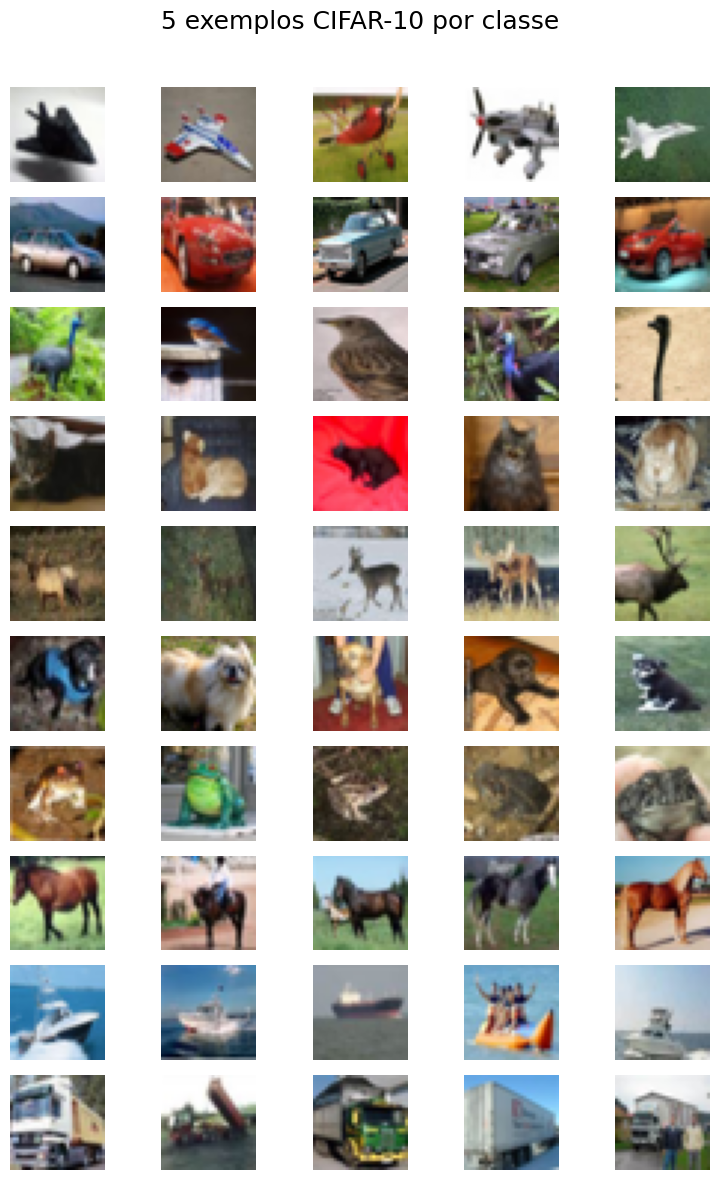

In [192]:
# Parâmetros
num_classes = 10
samples_per_class = 5

# Nomes das classes do CIFAR-10
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Containers
class_counts = {i: 0 for i in range(num_classes)}
class_images = {i: [] for i in range(num_classes)}

# Coleta até 5 imagens por classe
for img, label in trainset:  # trainset do CIFAR-10
    if class_counts[label] < samples_per_class:
        class_images[label].append(img)
        class_counts[label] += 1
    if all(count >= samples_per_class for count in class_counts.values()):
        break

# Função para “desnormalizar” (opcional)
def denormalize(img):
    return img * 0.5 + 0.5  # considerando Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))

# Plot
fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(8, 12))
for cls in range(num_classes):
    for i in range(samples_per_class):
        ax = axes[cls, i]
        img = class_images[cls][i]      # tensor C×H×W
        img = denormalize(img)          # opcional
        img = img.permute(1, 2, 0)      # H×W×C
        ax.imshow(img.numpy())
        ax.axis('off')

plt.suptitle("5 exemplos CIFAR-10 por classe", fontsize=18)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

### Treinamento do modelo classificador nos dados reais

In [193]:
net = Net()

In [194]:
import torch.optim as optim

In [195]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [196]:
train_classifier(net=net, mode="cent", data_type="real", trainloader=trainloader, epochs=100, optimizer=optimizer)

[1,   782] loss: 2.299
[2,   782] loss: 2.197
[3,   782] loss: 1.936
[4,   782] loss: 1.724
[5,   782] loss: 1.583
[6,   782] loss: 1.510
[7,   782] loss: 1.456
[8,   782] loss: 1.410
[9,   782] loss: 1.373
[10,   782] loss: 1.335
[11,   782] loss: 1.297
[12,   782] loss: 1.266
[13,   782] loss: 1.233
[14,   782] loss: 1.201
[15,   782] loss: 1.175
[16,   782] loss: 1.147
[17,   782] loss: 1.122
[18,   782] loss: 1.101
[19,   782] loss: 1.078
[20,   782] loss: 1.053
[21,   782] loss: 1.036
[22,   782] loss: 1.017
[23,   782] loss: 0.999
[24,   782] loss: 0.982
[25,   782] loss: 0.959
[26,   782] loss: 0.948
[27,   782] loss: 0.929
[28,   782] loss: 0.913
[29,   782] loss: 0.901
[30,   782] loss: 0.882
[31,   782] loss: 0.869
[32,   782] loss: 0.851
[33,   782] loss: 0.835
[34,   782] loss: 0.825
[35,   782] loss: 0.811
[36,   782] loss: 0.799
[37,   782] loss: 0.788
[38,   782] loss: 0.769
[39,   782] loss: 0.759
[40,   782] loss: 0.746
[41,   782] loss: 0.734
[42,   782] loss: 0.721
[

#### Avaliação do modelo

In [28]:
import matplotlib.pyplot as plt

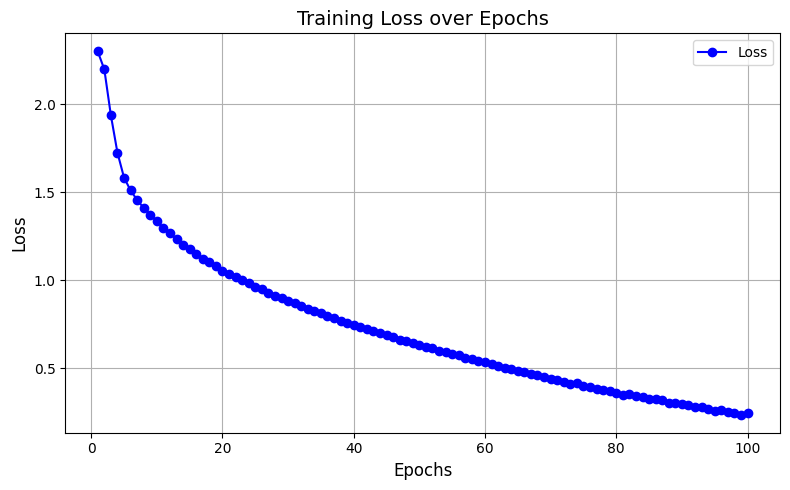

In [29]:
# Dados: número de rodadas (1 a 100) e respectivos valores de loss
epochs = list(range(1, 101))
loss_values = [
    2.299, 2.197, 1.936, 1.724, 1.583, 1.510, 1.456, 1.410, 1.373, 1.335,
    1.297, 1.266, 1.233, 1.201, 1.175, 1.147, 1.122, 1.101, 1.078, 1.053,
    1.036, 1.017, 0.999, 0.982, 0.959, 0.948, 0.929, 0.913, 0.901, 0.882,
    0.869, 0.851, 0.835, 0.825, 0.811, 0.799, 0.788, 0.769, 0.759, 0.746,
    0.734, 0.721, 0.712, 0.702, 0.688, 0.677, 0.663, 0.656, 0.641, 0.634,
    0.622, 0.614, 0.600, 0.593, 0.582, 0.573, 0.558, 0.552, 0.540, 0.534,
    0.523, 0.515, 0.502, 0.495, 0.483, 0.477, 0.468, 0.459, 0.451, 0.438,
    0.434, 0.424, 0.413, 0.414, 0.397, 0.396, 0.383, 0.376, 0.369, 0.362,
    0.349, 0.352, 0.342, 0.334, 0.326, 0.324, 0.317, 0.305, 0.303, 0.298,
    0.290, 0.282, 0.282, 0.270, 0.258, 0.265, 0.253, 0.246, 0.237, 0.244
]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b', label='Loss')

# Configurações do gráfico
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss over Epochs', fontsize=14)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [197]:
acc = eval_classifier(net=net, testloader=testloader)
print(f'Accuracy of the network: {acc:.2f}%')

Accuracy of the network: 61.87%


Se precisar salvar e carregar modelo:

In [198]:
# PATH = f'./cifar_net_{mode}_{data_type}_{epoch}e.pth'
# if IN_COLAB:
#     PATH = os.path.join(save_dir, f'cifar_net_{mode}_{data_type}_{epoch}e.pth')
# torch.save(net.state_dict(), PATH)

In [199]:
# net = Net()
# net.load_state_dict(torch.load(PATH, weights_only=True))

### Treinamento do modelo generativo

In [234]:
LEARNING_RATE = 0.0002
BETA1 = 0.5
BETA2 = 0.999

model = F2U_GAN_CIFAR().to(device)
optimizer_G = torch.optim.Adam(model.generator.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
optimizer_D = torch.optim.Adam(model.discriminator.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

In [ ]:
train_gan(model=model, optimizer_D=optimizer_D, optimizer_G=optimizer_G, trainloader=trainloader, epochs=200, e_to_save=5, mode_for_filename="cent_real")

#### Avaliação do modelo

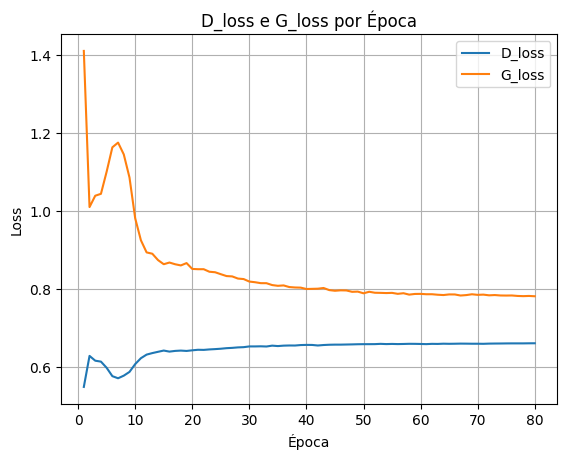

In [32]:
epochs = []
d_losses = []
g_losses = []

with open("Treino_cifar.txt", 'r') as f:
    for line in f:
        parts = [p.strip() for p in line.split(',')]
        epoch = int(parts[0].split(':')[1])
        d_loss = float(parts[1].split(':')[1])
        g_loss = float(parts[2].split(':')[1])
        
        epochs.append(epoch)
        d_losses.append(d_loss)
        g_losses.append(g_loss)

plt.figure()
plt.plot(epochs, d_losses, label='D_loss')
plt.plot(epochs, g_losses, label='G_loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('D_loss e G_loss por Época')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
for i in range(1, 197, 10):
    # 1) Carrega o checkpoint
    checkpoint = torch.load(f'Treino_CGAN_cent/checkpoint_epoch{i}.pth', map_location=torch.device('cpu'))

    model = F2U_GAN_CIFAR()

    model.discriminator.load_state_dict(checkpoint['disc_state_dict'])

    model.generator.load_state_dict(checkpoint['gen_state_dict'])

    generate_plot(net=model, device="cpu", round_number=i, mode_dist="cent", latent_dim=128)

Imagem salva: cifar10_cent_r1.png
Imagem salva: cifar10_cent_r11.png
Imagem salva: cifar10_cent_r21.png
Imagem salva: cifar10_cent_r31.png
Imagem salva: cifar10_cent_r41.png
Imagem salva: cifar10_cent_r51.png
Imagem salva: cifar10_cent_r61.png
Imagem salva: cifar10_cent_r71.png
Imagem salva: cifar10_cent_r81.png
Imagem salva: cifar10_cent_r91.png
Imagem salva: cifar10_cent_r101.png
Imagem salva: cifar10_cent_r111.png
Imagem salva: cifar10_cent_r121.png
Imagem salva: cifar10_cent_r131.png
Imagem salva: cifar10_cent_r141.png
Imagem salva: cifar10_cent_r151.png
Imagem salva: cifar10_cent_r161.png
Imagem salva: cifar10_cent_r171.png
Imagem salva: cifar10_cent_r181.png
Imagem salva: cifar10_cent_r191.png


### Treinamento do modelo classificador em dados sintéticos

#### Geração de dados com modelo treinado

In [239]:
# Parameters
num_samples = 6000
latent_dim = 128

# model = F2U_GAN_CIFAR()
# model.load_state_dict(torch.load(f"gen_round{}.pt", map_location=torch.device('cpu')))

# Create the dataset and dataloader
generated_dataset = GeneratedDataset(generator=model.to("cpu"), num_samples=num_samples, latent_dim=latent_dim, num_classes=10, device="cpu")
generated_dataloader = DataLoader(generated_dataset, batch_size=64, shuffle=True)

#### Treinamento

In [240]:
net = Net()

In [241]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [242]:
train_classifier(net=net, mode="cent", optimizer=optimizer, data_type="syn", trainloader=generated_dataloader, epochs=100)

[1,    94] loss: 2.303
[2,    94] loss: 2.301
[3,    94] loss: 2.300
[4,    94] loss: 2.298
[5,    94] loss: 2.296
[6,    94] loss: 2.293
[7,    94] loss: 2.288
[8,    94] loss: 2.279
[9,    94] loss: 2.261
[10,    94] loss: 2.222
[11,    94] loss: 2.150
[12,    94] loss: 2.091
[13,    94] loss: 2.050
[14,    94] loss: 2.014
[15,    94] loss: 1.977
[16,    94] loss: 1.937
[17,    94] loss: 1.905
[18,    94] loss: 1.872
[19,    94] loss: 1.845
[20,    94] loss: 1.814
[21,    94] loss: 1.788
[22,    94] loss: 1.746
[23,    94] loss: 1.714
[24,    94] loss: 1.678
[25,    94] loss: 1.643
[26,    94] loss: 1.612
[27,    94] loss: 1.592
[28,    94] loss: 1.559
[29,    94] loss: 1.533
[30,    94] loss: 1.513
[31,    94] loss: 1.494
[32,    94] loss: 1.470
[33,    94] loss: 1.440
[34,    94] loss: 1.419
[35,    94] loss: 1.405
[36,    94] loss: 1.376
[37,    94] loss: 1.365
[38,    94] loss: 1.350
[39,    94] loss: 1.329
[40,    94] loss: 1.299
[41,    94] loss: 1.276
[42,    94] loss: 1.265
[

In [243]:
eval_classifier(net=net, testloader=testloader)

40.67

##### Salva o Modelo

In [245]:
PATH = f'./cifar_net_syn_cent.pth'
if IN_COLAB:
    PATH = os.path.join(save_dir, f'cifar_net_sintetico_{epoch}e.pth')
torch.save(net.state_dict(), PATH)

## Federado

In [246]:
if IN_COLAB:
    !pip install flwr_datasets
    !pip install flwr

In [11]:
from flwr_datasets.partitioner import DirichletPartitioner, IidPartitioner, ShardPartitioner
from flwr_datasets.visualization import plot_label_distributions
from flwr_datasets import FederatedDataset
from torchvision.transforms import Compose, ToTensor, Normalize

In [12]:
# Para CIFAR-10: 3 canais, normalização média=0.5 e std=0.5
pytorch_transforms = Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def apply_transforms(batch):
    # batch["image"] é uma lista de PIL.Image ou tensores em H×W×C
    # aplicamos o mesmo transform a cada imagem e depois empilhamos
    batch["img"] = torch.stack([pytorch_transforms(img) for img in batch["img"]])
    return batch

In [43]:
num_partitions = 10
alpha_dir = 0.1

### IID

#### Carregamento e particionamento dos dados

In [48]:
partitioner = IidPartitioner(
    num_partitions=num_partitions
)

In [49]:
fds = FederatedDataset(
    dataset="cifar10",
    partitioners={"train": partitioner}
)

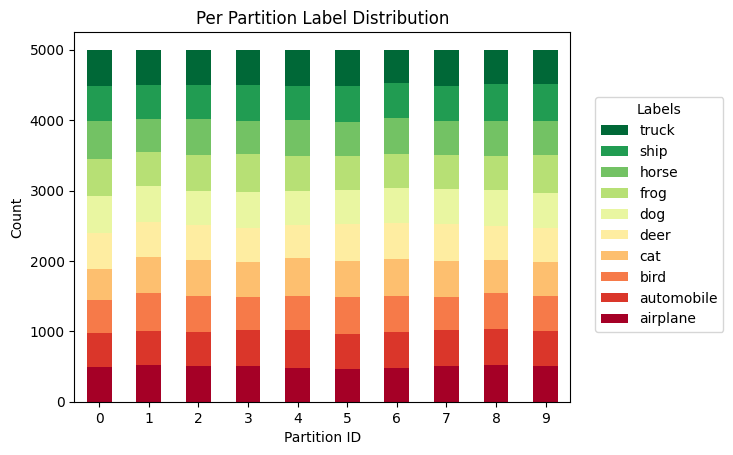

In [50]:
partitioner = fds.partitioners["train"]
figure, axis, dataframe = plot_label_distributions(
    partitioner=partitioner,
    label_name="label",
    title="Per Partition Label Distribution",
    legend=True,
    verbose_labels=True,
    size_unit="absolute",
    partition_id_axis="x",
)

In [51]:
train_partitions = [fds.load_partition(i, split="train") for i in range(num_partitions)]

Rodar proxima celula somente se quiser testar com dataset reduzido

In [ ]:
# num_samples = [int(len(train_partition)/10) for train_partition in train_partitions]
# train_partitions = [train_partition.select(range(n)) for train_partition, n in zip(train_partitions, num_samples)]

In [52]:
train_partitions = [train_partition.with_transform(apply_transforms) for train_partition in train_partitions]

c:\Users\55199\Mestrado\gerafed_env312\Lib\site-packages\datasets\utils\_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


In [53]:
batch_size = 64
trainloaders = [DataLoader(train_partition, batch_size=batch_size, shuffle=True) for train_partition in train_partitions]

In [54]:
test_partition = fds.load_split("test")
test_partition = test_partition.with_transform(apply_transforms)
testloader = DataLoader(test_partition, batch_size=batch_size)

c:\Users\55199\Mestrado\gerafed_env312\Lib\site-packages\datasets\utils\_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


#### Trinamento modelo classificador com dados reais

In [313]:
nets = [Net() for _ in range(num_partitions)]

In [314]:
criterion = nn.CrossEntropyLoss()
optimizers = [optim.SGD(net.parameters(), lr=0.1, momentum=0.9) for net in nets]

In [259]:
from flwr.server.strategy.aggregate import aggregate_inplace
from flwr.common import FitRes, Status, Code, ndarrays_to_parameters
from collections import OrderedDict

##### FedAvg

In [ ]:
rounds = 200
accuracies = []
global_net = Net().to(device)
round_bar = tqdm(range(rounds), desc="Rounds", unit="round", leave=True, position=0)
for r in round_bar:
    current_round_results = []
    client_data_for_this_round = list(zip(nets, optimizers, trainloaders))
    
    # Recrie a barra de progresso dos clientes para esta rodada
    client_progress_this_round = tqdm(
        enumerate(client_data_for_this_round),
        desc=f"Clients (Round {r+1})",
        unit="client",
        leave=False,  # Para que a barra do cliente desapareça após a conclusão da rodada de clientes
        position=1,   # Para aninhar abaixo da barra de rodadas
        total=len(client_data_for_this_round) # Necessário para tqdm saber o total de iterações
    )

    for i, (net, optimizer, trainloader) in client_progress_this_round:
        if r > 0:  # Carrega o modelo global a partir da segunda rodada
            net.load_state_dict(global_net.state_dict(), strict=True)
        
        train_classifier(net=net, mode="fed", data_type="real", epochs=1, optimizer=optimizer, trainloader=trainloader)


        client_trained_params_ndarrays = [val.cpu().numpy() for _, val in net.state_dict().items()]
        client_trained_parameters_proto = ndarrays_to_parameters(client_trained_params_ndarrays)

        current_round_results.append(
            ( # Flower geralmente espera (client_proxy, fit_res)
              # Mantendo sua estrutura (índice, FitRes)
              i, 
              FitRes(
                  status=Status(code=Code.OK, message="Success"),
                  parameters=client_trained_parameters_proto,
                  num_examples=len(trainloader.dataset), # Assegure que trainloader.dataset existe
                  metrics={}
              )
            )
        )
    
    client_progress_this_round.close() # Feche a barra de progresso interna

    # Verifique se houve resultados de clientes antes de agregar
    if not current_round_results:
        print(f"Alerta: Rodada {r+1}/{rounds} não produziu resultados de clientes. Agregação pulada.")
        # Decida como lidar com isso: usar acurácia anterior, registrar erro, etc.
        last_acc = accuracies[-1] if accuracies else 0.0  # Use a última acurácia conhecida ou 0
        accuracies.append(last_acc)
        round_bar.set_description(f"Round {r+1}/{rounds} | Global Accuracy: {last_acc:.2f}% (Sem dados)")
        print(f"Round {r+1}/{rounds} | Global Accuracy: {last_acc:.2f}% (Sem dados de clientes nesta rodada)")
        continue # Pula para a próxima rodada

    # Agregue os resultados SOMENTE da rodada atual
    aggregated_ndarrays = aggregate_inplace(current_round_results)
    
    params_dict = zip(global_net.state_dict().keys(), aggregated_ndarrays)
    state_dict = OrderedDict({k: torch.tensor(v).to(device) for k, v in params_dict})
    global_net.load_state_dict(state_dict, strict=True)
    
    acc = eval_classifier(net=global_net, testloader=testloader, mode="fed")
    accuracies.append(acc)
    
    print(f"Round {r+1}/{rounds} | Global Accuracy: {acc:.2f}%")
    with open("cifar_fed_iid.txt", "a") as f:
        f.write(f"Round {r+1}/{rounds} | Global Accuracy: {acc:.2f}%\n")
    round_bar.set_description(f"Round {r+1}/{rounds} | Global Accuracy: {acc:.2f}%")


##### FedProx

In [ ]:
rounds = 200
accuracies = []
global_net = Net().to(device)
round_bar = tqdm(range(rounds), desc="Rounds", unit="round", leave=True, position=0)
for r in round_bar:
    current_round_results = []
    client_data_for_this_round = list(zip(nets, optimizers, trainloaders))
    
    # Recrie a barra de progresso dos clientes para esta rodada
    client_progress_this_round = tqdm(
        enumerate(client_data_for_this_round),
        desc=f"Clients (Round {r+1})",
        unit="client",
        leave=False,  # Para que a barra do cliente desapareça após a conclusão da rodada de clientes
        position=1,   # Para aninhar abaixo da barra de rodadas
        total=len(client_data_for_this_round) # Necessário para tqdm saber o total de iterações
    )

    for i, (net, optimizer, trainloader) in client_progress_this_round:
        if r > 0:  # Carrega o modelo global a partir da segunda rodada
            net.load_state_dict(global_net.state_dict(), strict=True)
        
        train_classifier(net=net, mode="fed", data_type="real", epochs=1, optimizer=optimizer, trainloader=trainloader)


        client_trained_params_ndarrays = [val.cpu().numpy() for _, val in net.state_dict().items()]
        client_trained_parameters_proto = ndarrays_to_parameters(client_trained_params_ndarrays)

        current_round_results.append(
            ( # Flower geralmente espera (client_proxy, fit_res)
              # Mantendo sua estrutura (índice, FitRes)
              i, 
              FitRes(
                  status=Status(code=Code.OK, message="Success"),
                  parameters=client_trained_parameters_proto,
                  num_examples=len(trainloader.dataset), # Assegure que trainloader.dataset existe
                  metrics={}
              )
            )
        )
    
    client_progress_this_round.close() # Feche a barra de progresso interna

    # Verifique se houve resultados de clientes antes de agregar
    if not current_round_results:
        print(f"Alerta: Rodada {r+1}/{rounds} não produziu resultados de clientes. Agregação pulada.")
        # Decida como lidar com isso: usar acurácia anterior, registrar erro, etc.
        last_acc = accuracies[-1] if accuracies else 0.0  # Use a última acurácia conhecida ou 0
        accuracies.append(last_acc)
        round_bar.set_description(f"Round {r+1}/{rounds} | Global Accuracy: {last_acc:.2f}% (Sem dados)")
        print(f"Round {r+1}/{rounds} | Global Accuracy: {last_acc:.2f}% (Sem dados de clientes nesta rodada)")
        continue # Pula para a próxima rodada

    # Agregue os resultados SOMENTE da rodada atual
    aggregated_ndarrays = aggregate_inplace(current_round_results)
    
    params_dict = zip(global_net.state_dict().keys(), aggregated_ndarrays)
    state_dict = OrderedDict({k: torch.tensor(v).to(device) for k, v in params_dict})
    global_net.load_state_dict(state_dict, strict=True)
    
    acc = eval_classifier(net=global_net, testloader=testloader, mode="fed")
    accuracies.append(acc)
    print(f"Round {r+1}/{rounds} | Global Accuracy: {acc:.2f}%")
    with open("cifar_fed_iid_fedprox(05).txt", "a") as f:
        f.write(f"Round {r+1}/{rounds} | Global Accuracy: {acc:.2f}%\n")
    round_bar.set_description(f"Round {r+1}/{rounds} | Global Accuracy: {acc:.2f}%")

#### Treinamento modelo generativo

##### F2U

In [224]:
discs = [F2U_GAN_CIFAR().to(device) for _ in range(num_partitions)]
gen = F2U_GAN_CIFAR().to(device)

In [ ]:
F2U_train(
    rounds=500,
    partition_dist="iid",
    train_partitions=train_partitions,
    models=discs,
    batch_size_disc=64,
    batch_size_gen=1,
    epochs_gen=100,
    gen=gen,
    latent_dim=128
)

In [36]:
loss_filename = "losses_fed_iid.json"

In [38]:
loaded_dict = open_lossfile(loss_filename)

Dictionary successfully loaded from losses_fed_iid.json
Loaded dictionary: {'g_losses_round': [0.15078607230038507, 0.28075817809416914, 0.23277487058541738, 0.34976205830322576, 0.2374834936808329, 0.3098844164905604, 0.3711910452560405, 0.2643678852934545, 0.4912830609111115, 0.4225863337831306, 0.33170387547463176, 0.2879671713082571, 0.3920489705153268, 0.33616555422591043, 0.4105889433313617, 0.2696411509270074, 0.36615782635100186, 0.29383613432664424, 0.31636638222448527, 0.24895390818011948, 0.2600350814566191, 0.24544999082485447, 0.22241627093957506, 0.11238500486848671, 0.21063341998570104, 0.1661728106988885, 0.1602889547336381, 0.03512883818224269, 0.03016864941300864, 0.036889829377499156, 0.060233165343905055, 0.04446597253519576, 0.012681411083719694, 0.044861077824149616, 0.03066442447554754, 0.0392938004822552, 0.04491870052937795, 0.0356488055442569, 0.013838972057495994, 0.010991854406997278, 0.032511759289206806, 0.10170150559098015, 0.09946073106372433, 0.06887284

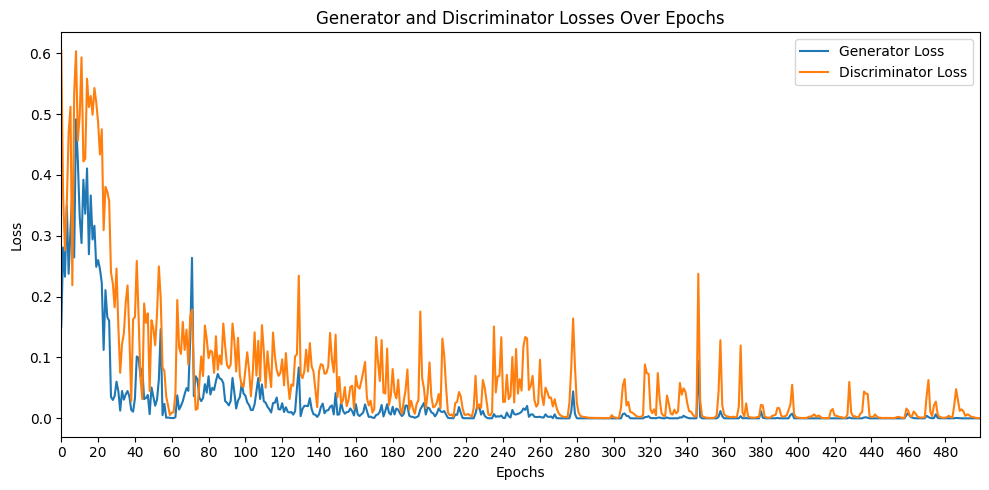

In [39]:
loss_graph(g_losses=loaded_dict["g_losses_round"], d_losses=loaded_dict["d_losses_round"], xtick_step=20)

##### FedAvg

In [41]:
from flwr.server.strategy.aggregate import aggregate_inplace
from flwr.common import FitRes, Status, Code, ndarrays_to_parameters
from collections import OrderedDict

In [55]:
gans = [F2U_GAN_CIFAR().to(device) for _ in range(num_partitions)]
optimizers_D = [
    torch.optim.Adam(disc.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999)) for disc in gans
]
optimizers_G = [
    torch.optim.Adam(gen.generator.parameters(), lr=0.0002, betas=(0.5, 0.999)) for gen in gans
]

In [ ]:
rounds = 200
global_gan = F2U_GAN_CIFAR().to(device)
round_bar = tqdm(range(rounds), desc="Rounds", unit="round", leave=True, position=0)
for r in round_bar:
    current_round_results = []
    client_data_for_this_round = list(zip(gans, optimizers_D, optimizers_G, trainloaders))
    
    # Recrie a barra de progresso dos clientes para esta rodada
    client_progress_this_round = tqdm(
        enumerate(client_data_for_this_round),
        desc=f"Clients (Round {r+1})",
        unit="client",
        leave=True,  # Para que a barra do cliente desapareça após a conclusão da rodada de clientes
        position=1,   # Para aninhar abaixo da barra de rodadas
        total=len(client_data_for_this_round) # Necessário para tqdm saber o total de iterações
    )

    for i, (gan, optimizer_D, optimizer_G, trainloader) in client_progress_this_round:
        if r > 0:  # Carrega o modelo global a partir da segunda rodada
            gan.load_state_dict(global_gan.state_dict(), strict=True)
        
       
        train_gan(
            model=gan,
            optimizer_D=optimizer_D,
            optimizer_G=optimizer_G,
            trainloader=trainloader,
            epochs=5,
            e_to_save=5, 
            mode_for_filename="fed_iid",
            client=i,  # Passa o índice do cliente para o gan
        )

        client_trained_params_ndarrays = [val.cpu().numpy() for _, val in gan.state_dict().items()]
        client_trained_parameters_proto = ndarrays_to_parameters(client_trained_params_ndarrays)

        current_round_results.append(
            ( # Flower geralmente espera (client_proxy, fit_res)
              # Mantendo sua estrutura (índice, FitRes)
              i, 
              FitRes(
                  status=Status(code=Code.OK, message="Success"),
                  parameters=client_trained_parameters_proto,
                  num_examples=len(trainloader.dataset), # Assegure que trainloader.dataset existe
                  metrics={}
              )
            )
        )
    
    client_progress_this_round.close() # Feche a barra de progresso interna

    # Verifique se houve resultados de clientes antes de agregar
    if not current_round_results:
        print(f"Alerta: Rodada {r+1}/{rounds} não produziu resultados de clientes. Agregação pulada.")
        # Decida como lidar com isso: usar acurácia anterior, registrar erro, etc.
        continue # Pula para a próxima rodada

    # Agregue os resultados SOMENTE da rodada atual
    aggregated_ndarrays = aggregate_inplace(current_round_results)
    
    params_dict = zip(global_gan.state_dict().keys(), aggregated_ndarrays)
    state_dict = OrderedDict({k: torch.tensor(v).to(device) for k, v in params_dict})
    global_gan.load_state_dict(state_dict, strict=True)

    # Avaliar o gerador global
    gen_loss, disc_loss = eval_gan(global_gan, testloader)

    print(f"Round {r+1}/{rounds} | Global Gen Test Loss: {gen_loss:.2f} | Global Disc Test Loss: {disc_loss:.2f}")
    with open("cifar_fed_iid.txt", "a") as f:
        f.write(f"Round {r+1}/{rounds} | Global Gen Test Loss: {gen_loss:.2f} | Global Disc Test Loss: {disc_loss:.2f}\n")
    round_bar.set_description(f"Round {r+1}/{rounds} | Global Gen Test Loss: {gen_loss:.2f} | Global Disc Test Loss: {disc_loss:.2f}")


In [57]:
torch.save(global_gan.state_dict(), "global_gan_fed_iid.pt")

##### FedProx

In [58]:
gans = [F2U_GAN_CIFAR().to(device) for _ in range(num_partitions)]
optimizers_D = [
    torch.optim.Adam(disc.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999)) for disc in gans
]
optimizers_G = [
    torch.optim.Adam(gen.generator.parameters(), lr=0.0002, betas=(0.5, 0.999)) for gen in gans
]

In [ ]:
rounds = 200
global_gan = F2U_GAN_CIFAR().to(device)
round_bar = tqdm(range(rounds), desc="Rounds", unit="round", leave=True, position=0)
for r in round_bar:
    current_round_results = []
    client_data_for_this_round = list(zip(gans, optimizers_D, optimizers_G, trainloaders))
    
    # Recrie a barra de progresso dos clientes para esta rodada
    client_progress_this_round = tqdm(
        enumerate(client_data_for_this_round),
        desc=f"Clients (Round {r+1})",
        unit="client",
        leave=True,  # Para que a barra do cliente desapareça após a conclusão da rodada de clientes
        position=1,   # Para aninhar abaixo da barra de rodadas
        total=len(client_data_for_this_round) # Necessário para tqdm saber o total de iterações
    )

    for i, (gan, optimizer_D, optimizer_G, trainloader) in client_progress_this_round:
        if r > 0:  # Carrega o modelo global a partir da segunda rodada
            gan.load_state_dict(global_gan.state_dict(), strict=True)
        
       
        train_gan(
            model=gan,
            optimizer_D=optimizer_D,
            optimizer_G=optimizer_G,
            trainloader=trainloader,
            epochs=5,  # Treina por 5 épocas por rodada
            e_to_save=5,  # Salva checkpoints a cada 5 épocas
            mode_for_filename="fed_iid",
            client=i,  # Passa o índice do cliente para o gan
        )

        client_trained_params_ndarrays = [val.cpu().numpy() for _, val in gan.state_dict().items()]
        client_trained_parameters_proto = ndarrays_to_parameters(client_trained_params_ndarrays)

        current_round_results.append(
            ( # Flower geralmente espera (client_proxy, fit_res)
              # Mantendo sua estrutura (índice, FitRes)
              i, 
              FitRes(
                  status=Status(code=Code.OK, message="Success"),
                  parameters=client_trained_parameters_proto,
                  num_examples=len(trainloader.dataset), # Assegure que trainloader.dataset existe
                  metrics={}
              )
            )
        )
    
    client_progress_this_round.close() # Feche a barra de progresso interna

    # Verifique se houve resultados de clientes antes de agregar
    if not current_round_results:
        print(f"Alerta: Rodada {r+1}/{rounds} não produziu resultados de clientes. Agregação pulada.")
        # Decida como lidar com isso: usar acurácia anterior, registrar erro, etc.
        continue # Pula para a próxima rodada

    # Agregue os resultados SOMENTE da rodada atual
    aggregated_ndarrays = aggregate_inplace(current_round_results)
    
    params_dict = zip(global_gan.state_dict().keys(), aggregated_ndarrays)
    state_dict = OrderedDict({k: torch.tensor(v).to(device) for k, v in params_dict})
    global_gan.load_state_dict(state_dict, strict=True)

    # Avaliar o gerador global
    gen_loss, disc_loss = eval_gan(global_gan, testloader)

    print(f"Round {r+1}/{rounds} | Global Gen Test Loss: {gen_loss:.2f} | Global Disc Test Loss: {disc_loss:.2f}")
    with open("cifar_fed_iid.txt", "a") as f:
        f.write(f"Round {r+1}/{rounds} | Global Gen Test Loss: {gen_loss:.2f} | Global Disc Test Loss: {disc_loss:.2f}\n")
    round_bar.set_description(f"Round {r+1}/{rounds} | Global Gen Test Loss: {gen_loss:.2f} | Global Disc Test Loss: {disc_loss:.2f}")


#### Treinamento do modelo classificador com dados sintéticos

In [317]:
# Parameters
num_samples = 6000
latent_dim = 128

model = F2U_GAN_CIFAR()
model.load_state_dict(torch.load(f"gen_fed_iid_round500.pt", map_location=torch.device('cpu')))

# Create the dataset and dataloader
generated_dataset = GeneratedDataset(generator=gen.to("cpu"), num_samples=num_samples, latent_dim=latent_dim, num_classes=10, device="cpu")
generated_dataloader = DataLoader(generated_dataset, batch_size=64, shuffle=True)

In [318]:
partitions = split_dataset_randomly(generated_dataset, num_partitions)

In [319]:
loaders = [
    DataLoader(part, batch_size=64, shuffle=True)
    for part in partitions
]

In [320]:
nets = [Net() for _ in range(num_partitions)]

In [321]:
criterion = nn.CrossEntropyLoss()
optimizers = [optim.SGD(net.parameters(), lr=0.1, momentum=0.9) for net in nets]

In [322]:
from flwr.server.strategy.aggregate import aggregate_inplace
from flwr.common import FitRes, Status, Code, ndarrays_to_parameters
from collections import OrderedDict

#### FedAvg

In [ ]:
rounds = 100
accuracies = []
global_net = Net().to(device)
round_bar = tqdm(range(rounds), desc="Rounds", unit="round", leave=True, position=0)
for r in round_bar:
    current_round_results = []
    client_data_for_this_round = list(zip(nets, optimizers, loaders))
    
    # Recrie a barra de progresso dos clientes para esta rodada
    client_progress_this_round = tqdm(
        enumerate(client_data_for_this_round),
        desc=f"Clients (Round {r+1})",
        unit="client",
        leave=False,  # Para que a barra do cliente desapareça após a conclusão da rodada de clientes
        position=1,   # Para aninhar abaixo da barra de rodadas
        total=len(client_data_for_this_round) # Necessário para tqdm saber o total de iterações
    )

    for i, (net, optimizer, trainloader) in client_progress_this_round:
        if r > 0:  # Carrega o modelo global a partir da segunda rodada
            net.load_state_dict(global_net.state_dict(), strict=True)
        
        train_classifier(net=net, mode="fed", data_type="real", epochs=1, optimizer=optimizer, trainloader=trainloader)


        client_trained_params_ndarrays = [val.cpu().numpy() for _, val in net.state_dict().items()]
        client_trained_parameters_proto = ndarrays_to_parameters(client_trained_params_ndarrays)

        current_round_results.append(
            ( # Flower geralmente espera (client_proxy, fit_res)
              # Mantendo sua estrutura (índice, FitRes)
              i, 
              FitRes(
                  status=Status(code=Code.OK, message="Success"),
                  parameters=client_trained_parameters_proto,
                  num_examples=len(trainloader.dataset), # Assegure que trainloader.dataset existe
                  metrics={}
              )
            )
        )
    
    client_progress_this_round.close() # Feche a barra de progresso interna

    # Verifique se houve resultados de clientes antes de agregar
    if not current_round_results:
        print(f"Alerta: Rodada {r+1}/{rounds} não produziu resultados de clientes. Agregação pulada.")
        # Decida como lidar com isso: usar acurácia anterior, registrar erro, etc.
        last_acc = accuracies[-1] if accuracies else 0.0  # Use a última acurácia conhecida ou 0
        accuracies.append(last_acc)
        round_bar.set_description(f"Round {r+1}/{rounds} | Global Accuracy: {last_acc:.2f}% (Sem dados)")
        print(f"Round {r+1}/{rounds} | Global Accuracy: {last_acc:.2f}% (Sem dados de clientes nesta rodada)")
        continue # Pula para a próxima rodada

    # Agregue os resultados SOMENTE da rodada atual
    aggregated_ndarrays = aggregate_inplace(current_round_results)
    
    params_dict = zip(global_net.state_dict().keys(), aggregated_ndarrays)
    state_dict = OrderedDict({k: torch.tensor(v).to(device) for k, v in params_dict})
    global_net.load_state_dict(state_dict, strict=True)
    
    acc = eval_classifier(net=global_net, testloader=testloader, mode="fed")
    accuracies.append(acc)
    print(f"Round {r+1}/{rounds} | Global Accuracy: {acc:.2f}%")
    with open("cifar_fed_iid_syn.txt", "a") as f:
        f.write(f"Round {r+1}/{rounds} | Global Accuracy: {acc:.2f}%\n")
    round_bar.set_description(f"Round {r+1}/{rounds} | Global Accuracy: {acc:.2f}%")

##### FedProx

In [ ]:
rounds = 100
accuracies = []
global_net = Net().to(device)
round_bar = tqdm(range(rounds), desc="Rounds", unit="round", leave=True, position=0)
for r in round_bar:
    current_round_results = []
    client_data_for_this_round = list(zip(nets, optimizers, loaders))
    
    # Recrie a barra de progresso dos clientes para esta rodada
    client_progress_this_round = tqdm(
        enumerate(client_data_for_this_round),
        desc=f"Clients (Round {r+1})",
        unit="client",
        leave=False,  # Para que a barra do cliente desapareça após a conclusão da rodada de clientes
        position=1,   # Para aninhar abaixo da barra de rodadas
        total=len(client_data_for_this_round) # Necessário para tqdm saber o total de iterações
    )

    for i, (net, optimizer, trainloader) in client_progress_this_round:
        if r > 0:  # Carrega o modelo global a partir da segunda rodada
            net.load_state_dict(global_net.state_dict(), strict=True)
        
        train_classifier(net=net, mode="fed", data_type="real", epochs=1, optimizer=optimizer, trainloader=trainloader)


        client_trained_params_ndarrays = [val.cpu().numpy() for _, val in net.state_dict().items()]
        client_trained_parameters_proto = ndarrays_to_parameters(client_trained_params_ndarrays)

        current_round_results.append(
            ( # Flower geralmente espera (client_proxy, fit_res)
              # Mantendo sua estrutura (índice, FitRes)
              i, 
              FitRes(
                  status=Status(code=Code.OK, message="Success"),
                  parameters=client_trained_parameters_proto,
                  num_examples=len(trainloader.dataset), # Assegure que trainloader.dataset existe
                  metrics={}
              )
            )
        )
    
    client_progress_this_round.close() # Feche a barra de progresso interna

    # Verifique se houve resultados de clientes antes de agregar
    if not current_round_results:
        print(f"Alerta: Rodada {r+1}/{rounds} não produziu resultados de clientes. Agregação pulada.")
        # Decida como lidar com isso: usar acurácia anterior, registrar erro, etc.
        last_acc = accuracies[-1] if accuracies else 0.0  # Use a última acurácia conhecida ou 0
        accuracies.append(last_acc)
        round_bar.set_description(f"Round {r+1}/{rounds} | Global Accuracy: {last_acc:.2f}% (Sem dados)")
        print(f"Round {r+1}/{rounds} | Global Accuracy: {last_acc:.2f}% (Sem dados de clientes nesta rodada)")
        continue # Pula para a próxima rodada

    # Agregue os resultados SOMENTE da rodada atual
    aggregated_ndarrays = aggregate_inplace(current_round_results)
    
    params_dict = zip(global_net.state_dict().keys(), aggregated_ndarrays)
    state_dict = OrderedDict({k: torch.tensor(v).to(device) for k, v in params_dict})
    global_net.load_state_dict(state_dict, strict=True)
    
    acc = eval_classifier(net=global_net, testloader=testloader, mode="fed")
    accuracies.append(acc)
    print(f"Round {r+1}/{rounds} | Global Accuracy: {acc:.2f}%")
    with open("cifar_fed_iid_syn_fedprox(05).txt", "a") as f:
        f.write(f"Round {r+1}/{rounds} | Global Accuracy: {acc:.2f}%\n")
    round_bar.set_description(f"Round {r+1}/{rounds} | Global Accuracy: {acc:.2f}%")

### Não IID

#### Carregamento e particionamento dos dados

In [59]:
partitioner = DirichletPartitioner(
    num_partitions=num_partitions,
    partition_by="label",
    alpha=alpha_dir,
    min_partition_size=0,
    self_balancing=False
)

In [60]:
fds = FederatedDataset(
    dataset="cifar10",
    partitioners={"train": partitioner}
)

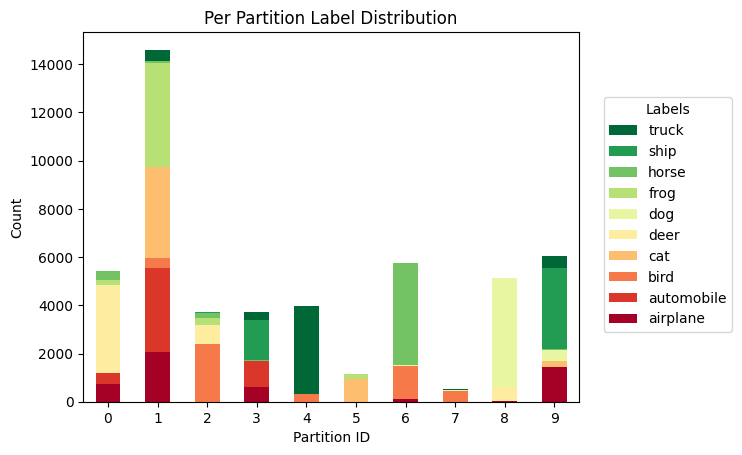

In [62]:
partitioner = fds.partitioners["train"]
figure, axis, dataframe = plot_label_distributions(
    partitioner=partitioner,
    label_name="label",
    title="Per Partition Label Distribution",
    legend=True,
    verbose_labels=True,
    size_unit="absolute",
    partition_id_axis="x",
)

In [63]:
train_partitions = [fds.load_partition(i, split="train") for i in range(num_partitions)]

Rodar proxima celula somente se quiser testar com dataset reduzido

In [ ]:
# num_samples = [int(len(train_partition)/10) for train_partition in train_partitions]
# train_partitions = [train_partition.select(range(n)) for train_partition, n in zip(train_partitions, num_samples)]

In [64]:
train_partitions = [train_partition.with_transform(apply_transforms) for train_partition in train_partitions]

c:\Users\55199\Mestrado\gerafed_env312\Lib\site-packages\datasets\utils\_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
c:\Users\55199\Mestrado\gerafed_env312\Lib\site-packages\datasets\utils\_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
c:\Users\55199\Mestrado\gerafed_env312\Lib\site-packages\datasets\utils\_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


In [65]:
batch_size = 64
trainloaders = [DataLoader(train_partition, batch_size=batch_size, shuffle=True) for train_partition in train_partitions]

#### Treinamento modelo classificador com dados reais

In [336]:
nets = [Net() for _ in range(num_partitions)]

In [337]:
criterion = nn.CrossEntropyLoss()
optimizers = [optim.SGD(net.parameters(), lr=0.1, momentum=0.9) for net in nets]

In [333]:
from flwr.server.strategy.aggregate import aggregate_inplace
from flwr.common import FitRes, Status, Code, ndarrays_to_parameters
from collections import OrderedDict

##### FedAvg

In [ ]:
rounds = 200
accuracies = []
global_net = Net().to(device)
round_bar = tqdm(range(rounds), desc="Rounds", unit="round", leave=True, position=0)
for r in round_bar:
    current_round_results = []
    client_data_for_this_round = list(zip(nets, optimizers, trainloaders))
    
    # Recrie a barra de progresso dos clientes para esta rodada
    client_progress_this_round = tqdm(
        enumerate(client_data_for_this_round),
        desc=f"Clients (Round {r+1})",
        unit="client",
        leave=False,  # Para que a barra do cliente desapareça após a conclusão da rodada de clientes
        position=1,   # Para aninhar abaixo da barra de rodadas
        total=len(client_data_for_this_round) # Necessário para tqdm saber o total de iterações
    )

    for i, (net, optimizer, trainloader) in client_progress_this_round:
        if r > 0:  # Carrega o modelo global a partir da segunda rodada
            net.load_state_dict(global_net.state_dict(), strict=True)
        
        train_classifier(net=net, mode="fed", data_type="real", epochs=1, optimizer=optimizer, trainloader=trainloader)


        client_trained_params_ndarrays = [val.cpu().numpy() for _, val in net.state_dict().items()]
        client_trained_parameters_proto = ndarrays_to_parameters(client_trained_params_ndarrays)

        current_round_results.append(
            ( # Flower geralmente espera (client_proxy, fit_res)
              # Mantendo sua estrutura (índice, FitRes)
              i, 
              FitRes(
                  status=Status(code=Code.OK, message="Success"),
                  parameters=client_trained_parameters_proto,
                  num_examples=len(trainloader.dataset), # Assegure que trainloader.dataset existe
                  metrics={}
              )
            )
        )
    
    client_progress_this_round.close() # Feche a barra de progresso interna

    # Verifique se houve resultados de clientes antes de agregar
    if not current_round_results:
        print(f"Alerta: Rodada {r+1}/{rounds} não produziu resultados de clientes. Agregação pulada.")
        # Decida como lidar com isso: usar acurácia anterior, registrar erro, etc.
        last_acc = accuracies[-1] if accuracies else 0.0  # Use a última acurácia conhecida ou 0
        accuracies.append(last_acc)
        round_bar.set_description(f"Round {r+1}/{rounds} | Global Accuracy: {last_acc:.2f}% (Sem dados)")
        print(f"Round {r+1}/{rounds} | Global Accuracy: {last_acc:.2f}% (Sem dados de clientes nesta rodada)")
        continue # Pula para a próxima rodada

    # Agregue os resultados SOMENTE da rodada atual
    aggregated_ndarrays = aggregate_inplace(current_round_results)
    
    params_dict = zip(global_net.state_dict().keys(), aggregated_ndarrays)
    state_dict = OrderedDict({k: torch.tensor(v).to(device) for k, v in params_dict})
    global_net.load_state_dict(state_dict, strict=True)
    
    acc = eval_classifier(net=global_net, testloader=testloader, mode="fed")
    accuracies.append(acc)
    print(f"Round {r+1}/{rounds} | Global Accuracy: {acc:.2f}%")
    with open("cifar_fed_Niid(dir01).txt", "a") as f:
        f.write(f"Round {r+1}/{rounds} | Global Accuracy: {acc:.2f}%\n")
    round_bar.set_description(f"Round {r+1}/{rounds} | Global Accuracy: {acc:.2f}%")

##### FedProx

In [ ]:
rounds = 200
accuracies = []
global_net = Net().to(device)
round_bar = tqdm(range(rounds), desc="Rounds", unit="round", leave=True, position=0)
for r in round_bar:
    current_round_results = []
    client_data_for_this_round = list(zip(nets, optimizers, trainloaders))
    
    # Recrie a barra de progresso dos clientes para esta rodada
    client_progress_this_round = tqdm(
        enumerate(client_data_for_this_round),
        desc=f"Clients (Round {r+1})",
        unit="client",
        leave=False,  # Para que a barra do cliente desapareça após a conclusão da rodada de clientes
        position=1,   # Para aninhar abaixo da barra de rodadas
        total=len(client_data_for_this_round) # Necessário para tqdm saber o total de iterações
    )

    for i, (net, optimizer, trainloader) in client_progress_this_round:
        if r > 0:  # Carrega o modelo global a partir da segunda rodada
            net.load_state_dict(global_net.state_dict(), strict=True)
        
        train_classifier(net=net, mode="fed", data_type="real", epochs=1, optimizer=optimizer, trainloader=trainloader)


        client_trained_params_ndarrays = [val.cpu().numpy() for _, val in net.state_dict().items()]
        client_trained_parameters_proto = ndarrays_to_parameters(client_trained_params_ndarrays)

        current_round_results.append(
            ( # Flower geralmente espera (client_proxy, fit_res)
              # Mantendo sua estrutura (índice, FitRes)
              i, 
              FitRes(
                  status=Status(code=Code.OK, message="Success"),
                  parameters=client_trained_parameters_proto,
                  num_examples=len(trainloader.dataset), # Assegure que trainloader.dataset existe
                  metrics={}
              )
            )
        )
    
    client_progress_this_round.close() # Feche a barra de progresso interna

    # Verifique se houve resultados de clientes antes de agregar
    if not current_round_results:
        print(f"Alerta: Rodada {r+1}/{rounds} não produziu resultados de clientes. Agregação pulada.")
        # Decida como lidar com isso: usar acurácia anterior, registrar erro, etc.
        last_acc = accuracies[-1] if accuracies else 0.0  # Use a última acurácia conhecida ou 0
        accuracies.append(last_acc)
        round_bar.set_description(f"Round {r+1}/{rounds} | Global Accuracy: {last_acc:.2f}% (Sem dados)")
        print(f"Round {r+1}/{rounds} | Global Accuracy: {last_acc:.2f}% (Sem dados de clientes nesta rodada)")
        continue # Pula para a próxima rodada

    # Agregue os resultados SOMENTE da rodada atual
    aggregated_ndarrays = aggregate_inplace(current_round_results)
    
    params_dict = zip(global_net.state_dict().keys(), aggregated_ndarrays)
    state_dict = OrderedDict({k: torch.tensor(v).to(device) for k, v in params_dict})
    global_net.load_state_dict(state_dict, strict=True)
    
    acc = eval_classifier(net=global_net, testloader=testloader, mode="fed")
    accuracies.append(acc)
    print(f"Round {r+1}/{rounds} | Global Accuracy: {acc:.2f}%")
    with open("cifar_fed_Niid(dir01)_fedprox(05).txt", "a") as f:
        f.write(f"Round {r+1}/{rounds} | Global Accuracy: {acc:.2f}%\n")
    round_bar.set_description(f"Round {r+1}/{rounds} | Global Accuracy: {acc:.2f}%")

#### Treinamento modelo generativo

##### F2U

In [ ]:
discs = [F2U_GAN_CIFAR().to(device) for _ in range(num_partitions)]
gen = F2U_GAN_CIFAR().to(device)

In [ ]:
F2U_train(
    rounds=500,
    partition_dist="Niid(dir01)",
    train_partitions=train_partitions,
    models=discs,
    batch_size_disc=64,
    batch_size_gen=1,
    epochs_gen=100,
    gen=gen,
    latent_dim=128
)

##### FedAvg

In [66]:
gans = [F2U_GAN_CIFAR().to(device) for _ in range(num_partitions)]
optimizers_D = [
    torch.optim.Adam(disc.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999)) for disc in gans
]
optimizers_G = [
    torch.optim.Adam(gen.generator.parameters(), lr=0.0002, betas=(0.5, 0.999)) for gen in gans
]

In [ ]:
rounds = 200
global_gan = F2U_GAN_CIFAR().to(device)
round_bar = tqdm(range(rounds), desc="Rounds", unit="round", leave=True, position=0)
for r in round_bar:
    current_round_results = []
    client_data_for_this_round = list(zip(gans, optimizers_D, optimizers_G, trainloaders))
    
    # Recrie a barra de progresso dos clientes para esta rodada
    client_progress_this_round = tqdm(
        enumerate(client_data_for_this_round),
        desc=f"Clients (Round {r+1})",
        unit="client",
        leave=True,  # Para que a barra do cliente desapareça após a conclusão da rodada de clientes
        position=1,   # Para aninhar abaixo da barra de rodadas
        total=len(client_data_for_this_round) # Necessário para tqdm saber o total de iterações
    )

    for i, (gan, optimizer_D, optimizer_G, trainloader) in client_progress_this_round:
        if r > 0:  # Carrega o modelo global a partir da segunda rodada
            gan.load_state_dict(global_gan.state_dict(), strict=True)
        
       
        train_gan(
            model=gan,
            optimizer_D=optimizer_D,
            optimizer_G=optimizer_G,
            trainloader=trainloader,
            epochs=5,
            e_to_save=5, 
            mode_for_filename="fed_iid",
            client=i,  # Passa o índice do cliente para o gan
        )

        client_trained_params_ndarrays = [val.cpu().numpy() for _, val in gan.state_dict().items()]
        client_trained_parameters_proto = ndarrays_to_parameters(client_trained_params_ndarrays)

        current_round_results.append(
            ( # Flower geralmente espera (client_proxy, fit_res)
              # Mantendo sua estrutura (índice, FitRes)
              i, 
              FitRes(
                  status=Status(code=Code.OK, message="Success"),
                  parameters=client_trained_parameters_proto,
                  num_examples=len(trainloader.dataset), # Assegure que trainloader.dataset existe
                  metrics={}
              )
            )
        )
    
    client_progress_this_round.close() # Feche a barra de progresso interna

    # Verifique se houve resultados de clientes antes de agregar
    if not current_round_results:
        print(f"Alerta: Rodada {r+1}/{rounds} não produziu resultados de clientes. Agregação pulada.")
        # Decida como lidar com isso: usar acurácia anterior, registrar erro, etc.
        continue # Pula para a próxima rodada

    # Agregue os resultados SOMENTE da rodada atual
    aggregated_ndarrays = aggregate_inplace(current_round_results)
    
    params_dict = zip(global_gan.state_dict().keys(), aggregated_ndarrays)
    state_dict = OrderedDict({k: torch.tensor(v).to(device) for k, v in params_dict})
    global_gan.load_state_dict(state_dict, strict=True)

    # Avaliar o gerador global
    gen_loss, disc_loss = eval_gan(global_gan, testloader)

    print(f"Round {r+1}/{rounds} | Global Gen Test Loss: {gen_loss:.2f} | Global Disc Test Loss: {disc_loss:.2f}")
    with open("cifar_fed_iid.txt", "a") as f:
        f.write(f"Round {r+1}/{rounds} | Global Gen Test Loss: {gen_loss:.2f} | Global Disc Test Loss: {disc_loss:.2f}\n")
    round_bar.set_description(f"Round {r+1}/{rounds} | Global Gen Test Loss: {gen_loss:.2f} | Global Disc Test Loss: {disc_loss:.2f}")
    if (r + 1) % 10 == 0:
        torch.save(global_gan.state_dict(), "global_gan_fed_Niid(dir01)_round_{}.pt".format(r+1))


##### FedProx

In [68]:
gans = [F2U_GAN_CIFAR().to(device) for _ in range(num_partitions)]
optimizers_D = [
    torch.optim.Adam(disc.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999)) for disc in gans
]
optimizers_G = [
    torch.optim.Adam(gen.generator.parameters(), lr=0.0002, betas=(0.5, 0.999)) for gen in gans
]

In [71]:
import copy

In [ ]:
rounds = 200
global_gan = F2U_GAN_CIFAR().to(device)
round_bar = tqdm(range(rounds), desc="Rounds", unit="round", leave=True, position=0)
for r in round_bar:
    current_round_results = []
    client_data_for_this_round = list(zip(gans, optimizers_D, optimizers_G, trainloaders))
    
    # Recrie a barra de progresso dos clientes para esta rodada
    client_progress_this_round = tqdm(
        enumerate(client_data_for_this_round),
        desc=f"Clients (Round {r+1})",
        unit="client",
        leave=True,  # Para que a barra do cliente desapareça após a conclusão da rodada de clientes
        position=1,   # Para aninhar abaixo da barra de rodadas
        total=len(client_data_for_this_round) # Necessário para tqdm saber o total de iterações
    )

    for i, (gan, optimizer_D, optimizer_G, trainloader) in client_progress_this_round:
        if r > 0:  # Carrega o modelo global a partir da segunda rodada
            gan.load_state_dict(global_gan.state_dict(), strict=True)
        
       
        train_gan(
            model=gan,
            optimizer_D=optimizer_D,
            optimizer_G=optimizer_G,
            trainloader=trainloader,
            epochs=5,
            e_to_save=5, 
            mode_for_filename="fedprox_Niid(01dir)",
            client=i,  # Passa o índice do cliente para o gan
        )

        client_trained_params_ndarrays = [val.cpu().numpy() for _, val in gan.state_dict().items()]
        client_trained_parameters_proto = ndarrays_to_parameters(client_trained_params_ndarrays)

        current_round_results.append(
            ( # Flower geralmente espera (client_proxy, fit_res)
              # Mantendo sua estrutura (índice, FitRes)
              i, 
              FitRes(
                  status=Status(code=Code.OK, message="Success"),
                  parameters=client_trained_parameters_proto,
                  num_examples=len(trainloader.dataset), # Assegure que trainloader.dataset existe
                  metrics={}
              )
            )
        )
    
    client_progress_this_round.close() # Feche a barra de progresso interna

    # Verifique se houve resultados de clientes antes de agregar
    if not current_round_results:
        print(f"Alerta: Rodada {r+1}/{rounds} não produziu resultados de clientes. Agregação pulada.")
        # Decida como lidar com isso: usar acurácia anterior, registrar erro, etc.
        continue # Pula para a próxima rodada

    # Agregue os resultados SOMENTE da rodada atual
    aggregated_ndarrays = aggregate_inplace(current_round_results)
    
    params_dict = zip(global_gan.state_dict().keys(), aggregated_ndarrays)
    state_dict = OrderedDict({k: torch.tensor(v).to(device) for k, v in params_dict})
    global_gan.load_state_dict(state_dict, strict=True)

    # Avaliar o gerador global
    gen_loss, disc_loss = eval_gan(global_gan, testloader)

    print(f"Round {r+1}/{rounds} | Global Gen Test Loss: {gen_loss:.2f} | Global Disc Test Loss: {disc_loss:.2f}")
    with open("cifar_fed_iid.txt", "a") as f:
        f.write(f"Round {r+1}/{rounds} | Global Gen Test Loss: {gen_loss:.2f} | Global Disc Test Loss: {disc_loss:.2f}\n")
    round_bar.set_description(f"Round {r+1}/{rounds} | Global Gen Test Loss: {gen_loss:.2f} | Global Disc Test Loss: {disc_loss:.2f}")
    if (r + 1) % 10 == 0:
        torch.save(global_gan.state_dict(), "global_gan_fed_Niid(dir01)_round_{}.pt".format(r+1))


##### Avaliação do modelo

In [280]:
loss_filename = "losses_fed_Niid(dir01).json"

In [ ]:
loaded_dict = open_lossfile(loss_filename)

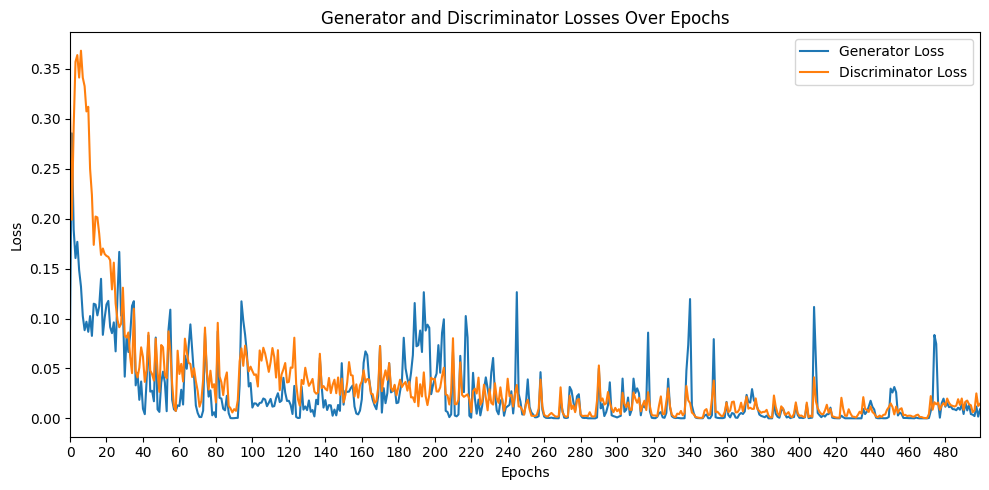

In [285]:
loss_graph(g_losses=loaded_dict["g_losses_round"], d_losses=loaded_dict["d_losses_round"], xtick_step=20)

In [83]:
for i in range(200,202,20):
    gen = F2U_GAN_CIFAR().to("cpu")
    gen.load_state_dict(torch.load(f"./Treino_CGAN_fed_NIIID_Full_FedProx/global_gan_fed_Niid(dir01)_round_{i}.pt", map_location=torch.device("cpu")))
    generate_plot(net=gen, device="cpu", round_number=i, latent_dim=128, mode_dist="fed_niid(dir01)_fullgan")

Imagem salva: cifar10_fed_niid(dir01)_fullgan_r200.png


#### Treinamento modelo classificador com dados sintéticos

In [107]:
# Parameters
num_samples = 6000
latent_dim = 128

model = F2U_GAN_CIFAR()
model.load_state_dict(torch.load(f"./Treino_CGAN_fed_NIIID_Full_FedProx/global_gan_fed_Niid(dir01)_round_200.pt", map_location=torch.device('cpu')))

# Create the dataset and dataloader
generated_dataset = GeneratedDataset(generator=gen.to("cpu"), num_samples=num_samples, latent_dim=latent_dim, num_classes=10, device="cpu")
generated_dataloader = DataLoader(generated_dataset, batch_size=64, shuffle=True)

In [108]:
partitions = split_dataset_randomly(generated_dataset, num_partitions)

In [109]:
loaders = [
    DataLoader(part, batch_size=64, shuffle=True)
    for part in partitions
]

In [110]:
nets = [Net() for _ in range(num_partitions)]

In [111]:
criterion = nn.CrossEntropyLoss()
optimizers = [torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9) for net in nets]

In [112]:
from flwr.server.strategy.aggregate import aggregate_inplace
from flwr.common import FitRes, Status, Code, ndarrays_to_parameters
from collections import OrderedDict

##### FedAvg

In [113]:
rounds = 50
accuracies = []
global_net = Net().to(device)
round_bar = tqdm(range(rounds), desc="Rounds", unit="round", leave=True, position=0)
for r in round_bar:
    current_round_results = []
    client_data_for_this_round = list(zip(nets, optimizers, loaders))
    
    # Recrie a barra de progresso dos clientes para esta rodada
    client_progress_this_round = tqdm(
        enumerate(client_data_for_this_round),
        desc=f"Clients (Round {r+1})",
        unit="client",
        leave=False,  # Para que a barra do cliente desapareça após a conclusão da rodada de clientes
        position=1,   # Para aninhar abaixo da barra de rodadas
        total=len(client_data_for_this_round) # Necessário para tqdm saber o total de iterações
    )

    for i, (net, optimizer, trainloader) in client_progress_this_round:
        if r > 0:  # Carrega o modelo global a partir da segunda rodada
            net.load_state_dict(global_net.state_dict(), strict=True)
        
        train_classifier(net=net, mode="fed", data_type="real", epochs=1, optimizer=optimizer, trainloader=trainloader)


        client_trained_params_ndarrays = [val.cpu().numpy() for _, val in net.state_dict().items()]
        client_trained_parameters_proto = ndarrays_to_parameters(client_trained_params_ndarrays)

        current_round_results.append(
            ( # Flower geralmente espera (client_proxy, fit_res)
              # Mantendo sua estrutura (índice, FitRes)
              i, 
              FitRes(
                  status=Status(code=Code.OK, message="Success"),
                  parameters=client_trained_parameters_proto,
                  num_examples=len(trainloader.dataset), # Assegure que trainloader.dataset existe
                  metrics={}
              )
            )
        )
    
    client_progress_this_round.close() # Feche a barra de progresso interna

    # Verifique se houve resultados de clientes antes de agregar
    if not current_round_results:
        print(f"Alerta: Rodada {r+1}/{rounds} não produziu resultados de clientes. Agregação pulada.")
        # Decida como lidar com isso: usar acurácia anterior, registrar erro, etc.
        last_acc = accuracies[-1] if accuracies else 0.0  # Use a última acurácia conhecida ou 0
        accuracies.append(last_acc)
        round_bar.set_description(f"Round {r+1}/{rounds} | Global Accuracy: {last_acc:.2f}% (Sem dados)")
        print(f"Round {r+1}/{rounds} | Global Accuracy: {last_acc:.2f}% (Sem dados de clientes nesta rodada)")
        continue # Pula para a próxima rodada

    # Agregue os resultados SOMENTE da rodada atual
    aggregated_ndarrays = aggregate_inplace(current_round_results)
    
    params_dict = zip(global_net.state_dict().keys(), aggregated_ndarrays)
    state_dict = OrderedDict({k: torch.tensor(v).to(device) for k, v in params_dict})
    global_net.load_state_dict(state_dict, strict=True)
    
    acc = eval_classifier(net=global_net, testloader=testloader, mode="fed")
    accuracies.append(acc)
    print(f"Round {r+1}/{rounds} | Global Accuracy: {acc:.2f}%")
    with open("cifar_fed_Niid(dir01)_syn.txt", "a") as f:
        f.write(f"Round {r+1}/{rounds} | Global Accuracy: {acc:.2f}%\n")
    round_bar.set_description(f"Round {r+1}/{rounds} | Global Accuracy: {acc:.2f}%")

Rounds:   0%|          | 0/50 [00:00<?, ?round/s]

Clients (Round 1):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 2.297
Finished Training
[1,    10] loss: 2.298
Finished Training
[1,    10] loss: 2.305
Finished Training
[1,    10] loss: 2.297
Finished Training
[1,    10] loss: 2.287
Finished Training
[1,    10] loss: 2.298
Finished Training
[1,    10] loss: 2.304
Finished Training
[1,    10] loss: 2.301
Finished Training
[1,    10] loss: 2.301
Finished Training
[1,    10] loss: 2.303
Finished Training
Round 1/50 | Global Accuracy: 10.00%


Clients (Round 2):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 2.301
Finished Training
[1,    10] loss: 2.304
Finished Training
[1,    10] loss: 2.302
Finished Training
[1,    10] loss: 2.302
Finished Training
[1,    10] loss: 2.302
Finished Training
[1,    10] loss: 2.299
Finished Training
[1,    10] loss: 2.306
Finished Training
[1,    10] loss: 2.302
Finished Training
[1,    10] loss: 2.303
Finished Training
[1,    10] loss: 2.306
Finished Training
Round 2/50 | Global Accuracy: 10.00%


Clients (Round 3):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 2.302
Finished Training
[1,    10] loss: 2.302
Finished Training
[1,    10] loss: 2.302
Finished Training
[1,    10] loss: 2.299
Finished Training
[1,    10] loss: 2.301
Finished Training
[1,    10] loss: 2.301
Finished Training
[1,    10] loss: 2.304
Finished Training
[1,    10] loss: 2.302
Finished Training
[1,    10] loss: 2.302
Finished Training
[1,    10] loss: 2.303
Finished Training
Round 3/50 | Global Accuracy: 10.00%


Clients (Round 4):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 2.301
Finished Training
[1,    10] loss: 2.304
Finished Training
[1,    10] loss: 2.305
Finished Training
[1,    10] loss: 2.299
Finished Training
[1,    10] loss: 2.300
Finished Training
[1,    10] loss: 2.300
Finished Training
[1,    10] loss: 2.304
Finished Training
[1,    10] loss: 2.304
Finished Training
[1,    10] loss: 2.301
Finished Training
[1,    10] loss: 2.302
Finished Training
Round 4/50 | Global Accuracy: 10.00%


Clients (Round 5):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 2.299
Finished Training
[1,    10] loss: 2.304
Finished Training
[1,    10] loss: 2.302
Finished Training
[1,    10] loss: 2.300
Finished Training
[1,    10] loss: 2.300
Finished Training
[1,    10] loss: 2.300
Finished Training
[1,    10] loss: 2.305
Finished Training
[1,    10] loss: 2.301
Finished Training
[1,    10] loss: 2.300
Finished Training
[1,    10] loss: 2.303
Finished Training
Round 5/50 | Global Accuracy: 10.00%


Clients (Round 6):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 2.302
Finished Training
[1,    10] loss: 2.304
Finished Training
[1,    10] loss: 2.304
Finished Training
[1,    10] loss: 2.300
Finished Training
[1,    10] loss: 2.301
Finished Training
[1,    10] loss: 2.298
Finished Training
[1,    10] loss: 2.304
Finished Training
[1,    10] loss: 2.304
Finished Training
[1,    10] loss: 2.300
Finished Training
[1,    10] loss: 2.303
Finished Training
Round 6/50 | Global Accuracy: 10.00%


Clients (Round 7):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 2.300
Finished Training
[1,    10] loss: 2.300
Finished Training
[1,    10] loss: 2.304
Finished Training
[1,    10] loss: 2.299
Finished Training
[1,    10] loss: 2.300
Finished Training
[1,    10] loss: 2.301
Finished Training
[1,    10] loss: 2.303
Finished Training
[1,    10] loss: 2.302
Finished Training
[1,    10] loss: 2.302
Finished Training
[1,    10] loss: 2.304
Finished Training
Round 7/50 | Global Accuracy: 12.52%


Clients (Round 8):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 2.296
Finished Training
[1,    10] loss: 2.298
Finished Training
[1,    10] loss: 2.300
Finished Training
[1,    10] loss: 2.295
Finished Training
[1,    10] loss: 2.297
Finished Training
[1,    10] loss: 2.298
Finished Training
[1,    10] loss: 2.297
Finished Training
[1,    10] loss: 2.299
Finished Training
[1,    10] loss: 2.300
Finished Training
[1,    10] loss: 2.298
Finished Training
Round 8/50 | Global Accuracy: 12.53%


Clients (Round 9):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 2.245
Finished Training
[1,    10] loss: 2.240
Finished Training
[1,    10] loss: 2.246
Finished Training
[1,    10] loss: 2.223
Finished Training
[1,    10] loss: 2.226
Finished Training
[1,    10] loss: 2.242
Finished Training
[1,    10] loss: 2.228
Finished Training
[1,    10] loss: 2.247
Finished Training
[1,    10] loss: 2.272
Finished Training
[1,    10] loss: 2.249
Finished Training
Round 9/50 | Global Accuracy: 11.64%


Clients (Round 10):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 2.113
Finished Training
[1,    10] loss: 2.132
Finished Training
[1,    10] loss: 2.121
Finished Training
[1,    10] loss: 2.146
Finished Training
[1,    10] loss: 2.097
Finished Training
[1,    10] loss: 2.124
Finished Training
[1,    10] loss: 2.104
Finished Training
[1,    10] loss: 2.172
Finished Training
[1,    10] loss: 2.157
Finished Training
[1,    10] loss: 2.126
Finished Training
Round 10/50 | Global Accuracy: 16.50%


Clients (Round 11):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 2.102
Finished Training
[1,    10] loss: 2.022
Finished Training
[1,    10] loss: 2.044
Finished Training
[1,    10] loss: 2.065
Finished Training
[1,    10] loss: 1.971
Finished Training
[1,    10] loss: 2.082
Finished Training
[1,    10] loss: 2.012
Finished Training
[1,    10] loss: 2.050
Finished Training
[1,    10] loss: 2.102
Finished Training
[1,    10] loss: 2.032
Finished Training
Round 11/50 | Global Accuracy: 16.58%


Clients (Round 12):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 1.871
Finished Training
[1,    10] loss: 1.830
Finished Training
[1,    10] loss: 1.841
Finished Training
[1,    10] loss: 1.946
Finished Training
[1,    10] loss: 1.743
Finished Training
[1,    10] loss: 1.825
Finished Training
[1,    10] loss: 1.773
Finished Training
[1,    10] loss: 1.885
Finished Training
[1,    10] loss: 1.868
Finished Training
[1,    10] loss: 1.787
Finished Training
Round 12/50 | Global Accuracy: 16.60%


Clients (Round 13):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 1.529
Finished Training
[1,    10] loss: 1.673
Finished Training
[1,    10] loss: 1.384
Finished Training
[1,    10] loss: 1.410
Finished Training
[1,    10] loss: 1.362
Finished Training
[1,    10] loss: 1.486
Finished Training
[1,    10] loss: 1.337
Finished Training
[1,    10] loss: 1.444
Finished Training
[1,    10] loss: 1.455
Finished Training
[1,    10] loss: 1.455
Finished Training
Round 13/50 | Global Accuracy: 13.41%


Clients (Round 14):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 1.370
Finished Training
[1,    10] loss: 1.354
Finished Training
[1,    10] loss: 1.303
Finished Training
[1,    10] loss: 1.268
Finished Training
[1,    10] loss: 1.267
Finished Training
[1,    10] loss: 1.304
Finished Training
[1,    10] loss: 1.350
Finished Training
[1,    10] loss: 1.329
Finished Training
[1,    10] loss: 1.428
Finished Training
[1,    10] loss: 1.263
Finished Training
Round 14/50 | Global Accuracy: 16.30%


Clients (Round 15):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 1.065
Finished Training
[1,    10] loss: 1.046
Finished Training
[1,    10] loss: 0.970
Finished Training
[1,    10] loss: 1.012
Finished Training
[1,    10] loss: 1.120
Finished Training
[1,    10] loss: 1.087
Finished Training
[1,    10] loss: 1.065
Finished Training
[1,    10] loss: 1.050
Finished Training
[1,    10] loss: 1.081
Finished Training
[1,    10] loss: 1.102
Finished Training
Round 15/50 | Global Accuracy: 19.19%


Clients (Round 16):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 1.025
Finished Training
[1,    10] loss: 0.853
Finished Training
[1,    10] loss: 0.765
Finished Training
[1,    10] loss: 0.863
Finished Training
[1,    10] loss: 0.899
Finished Training
[1,    10] loss: 0.857
Finished Training
[1,    10] loss: 1.028
Finished Training
[1,    10] loss: 0.948
Finished Training
[1,    10] loss: 0.928
Finished Training
[1,    10] loss: 0.943
Finished Training
Round 16/50 | Global Accuracy: 19.51%


Clients (Round 17):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.655
Finished Training
[1,    10] loss: 0.779
Finished Training
[1,    10] loss: 0.569
Finished Training
[1,    10] loss: 0.841
Finished Training
[1,    10] loss: 0.710
Finished Training
[1,    10] loss: 0.612
Finished Training
[1,    10] loss: 0.936
Finished Training
[1,    10] loss: 0.895
Finished Training
[1,    10] loss: 0.819
Finished Training
[1,    10] loss: 0.653
Finished Training
Round 17/50 | Global Accuracy: 20.38%


Clients (Round 18):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.543
Finished Training
[1,    10] loss: 0.676
Finished Training
[1,    10] loss: 0.516
Finished Training
[1,    10] loss: 0.588
Finished Training
[1,    10] loss: 0.531
Finished Training
[1,    10] loss: 0.513
Finished Training
[1,    10] loss: 0.724
Finished Training
[1,    10] loss: 0.655
Finished Training
[1,    10] loss: 0.537
Finished Training
[1,    10] loss: 0.633
Finished Training
Round 18/50 | Global Accuracy: 21.51%


Clients (Round 19):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.410
Finished Training
[1,    10] loss: 0.517
Finished Training
[1,    10] loss: 0.335
Finished Training
[1,    10] loss: 0.427
Finished Training
[1,    10] loss: 0.313
Finished Training
[1,    10] loss: 0.323
Finished Training
[1,    10] loss: 0.524
Finished Training
[1,    10] loss: 0.403
Finished Training
[1,    10] loss: 0.324
Finished Training
[1,    10] loss: 0.421
Finished Training
Round 19/50 | Global Accuracy: 21.08%


Clients (Round 20):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.447
Finished Training
[1,    10] loss: 0.286
Finished Training
[1,    10] loss: 0.288
Finished Training
[1,    10] loss: 0.430
Finished Training
[1,    10] loss: 0.226
Finished Training
[1,    10] loss: 0.191
Finished Training
[1,    10] loss: 0.324
Finished Training
[1,    10] loss: 0.257
Finished Training
[1,    10] loss: 0.388
Finished Training
[1,    10] loss: 0.243
Finished Training
Round 20/50 | Global Accuracy: 22.19%


Clients (Round 21):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.284
Finished Training
[1,    10] loss: 0.203
Finished Training
[1,    10] loss: 0.280
Finished Training
[1,    10] loss: 0.355
Finished Training
[1,    10] loss: 0.301
Finished Training
[1,    10] loss: 0.204
Finished Training
[1,    10] loss: 0.264
Finished Training
[1,    10] loss: 0.296
Finished Training
[1,    10] loss: 0.314
Finished Training
[1,    10] loss: 0.432
Finished Training
Round 21/50 | Global Accuracy: 22.61%


Clients (Round 22):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.172
Finished Training
[1,    10] loss: 0.186
Finished Training
[1,    10] loss: 0.190
Finished Training
[1,    10] loss: 0.242
Finished Training
[1,    10] loss: 0.192
Finished Training
[1,    10] loss: 0.158
Finished Training
[1,    10] loss: 0.221
Finished Training
[1,    10] loss: 0.186
Finished Training
[1,    10] loss: 0.188
Finished Training
[1,    10] loss: 0.247
Finished Training
Round 22/50 | Global Accuracy: 22.54%


Clients (Round 23):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.158
Finished Training
[1,    10] loss: 0.318
Finished Training
[1,    10] loss: 0.087
Finished Training
[1,    10] loss: 0.143
Finished Training
[1,    10] loss: 0.058
Finished Training
[1,    10] loss: 0.095
Finished Training
[1,    10] loss: 0.126
Finished Training
[1,    10] loss: 0.107
Finished Training
[1,    10] loss: 0.303
Finished Training
[1,    10] loss: 0.141
Finished Training
Round 23/50 | Global Accuracy: 22.18%


Clients (Round 24):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.328
Finished Training
[1,    10] loss: 0.270
Finished Training
[1,    10] loss: 0.119
Finished Training
[1,    10] loss: 0.233
Finished Training
[1,    10] loss: 0.049
Finished Training
[1,    10] loss: 0.088
Finished Training
[1,    10] loss: 0.101
Finished Training
[1,    10] loss: 0.097
Finished Training
[1,    10] loss: 0.132
Finished Training
[1,    10] loss: 0.092
Finished Training
Round 24/50 | Global Accuracy: 21.72%


Clients (Round 25):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.108
Finished Training
[1,    10] loss: 0.144
Finished Training
[1,    10] loss: 0.062
Finished Training
[1,    10] loss: 0.128
Finished Training
[1,    10] loss: 0.046
Finished Training
[1,    10] loss: 0.048
Finished Training
[1,    10] loss: 0.046
Finished Training
[1,    10] loss: 0.062
Finished Training
[1,    10] loss: 0.068
Finished Training
[1,    10] loss: 0.046
Finished Training
Round 25/50 | Global Accuracy: 22.73%


Clients (Round 26):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.052
Finished Training
[1,    10] loss: 0.068
Finished Training
[1,    10] loss: 0.040
Finished Training
[1,    10] loss: 0.093
Finished Training
[1,    10] loss: 0.032
Finished Training
[1,    10] loss: 0.039
Finished Training
[1,    10] loss: 0.027
Finished Training
[1,    10] loss: 0.030
Finished Training
[1,    10] loss: 0.040
Finished Training
[1,    10] loss: 0.032
Finished Training
Round 26/50 | Global Accuracy: 20.91%


Clients (Round 27):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.034
Finished Training
[1,    10] loss: 0.060
Finished Training
[1,    10] loss: 0.018
Finished Training
[1,    10] loss: 0.070
Finished Training
[1,    10] loss: 0.033
Finished Training
[1,    10] loss: 0.021
Finished Training
[1,    10] loss: 0.092
Finished Training
[1,    10] loss: 0.037
Finished Training
[1,    10] loss: 0.026
Finished Training
[1,    10] loss: 0.014
Finished Training
Round 27/50 | Global Accuracy: 21.51%


Clients (Round 28):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.125
Finished Training
[1,    10] loss: 0.036
Finished Training
[1,    10] loss: 0.014
Finished Training
[1,    10] loss: 0.059
Finished Training
[1,    10] loss: 0.039
Finished Training
[1,    10] loss: 0.022
Finished Training
[1,    10] loss: 0.076
Finished Training
[1,    10] loss: 0.066
Finished Training
[1,    10] loss: 0.025
Finished Training
[1,    10] loss: 0.014
Finished Training
Round 28/50 | Global Accuracy: 23.07%


Clients (Round 29):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.033
Finished Training
[1,    10] loss: 0.018
Finished Training
[1,    10] loss: 0.026
Finished Training
[1,    10] loss: 0.031
Finished Training
[1,    10] loss: 0.077
Finished Training
[1,    10] loss: 0.054
Finished Training
[1,    10] loss: 0.035
Finished Training
[1,    10] loss: 0.120
Finished Training
[1,    10] loss: 0.041
Finished Training
[1,    10] loss: 0.021
Finished Training
Round 29/50 | Global Accuracy: 20.17%


Clients (Round 30):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.018
Finished Training
[1,    10] loss: 0.018
Finished Training
[1,    10] loss: 0.024
Finished Training
[1,    10] loss: 0.023
Finished Training
[1,    10] loss: 0.043
Finished Training
[1,    10] loss: 0.028
Finished Training
[1,    10] loss: 0.019
Finished Training
[1,    10] loss: 0.080
Finished Training
[1,    10] loss: 0.034
Finished Training
[1,    10] loss: 0.011
Finished Training
Round 30/50 | Global Accuracy: 21.51%


Clients (Round 31):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.007
Finished Training
[1,    10] loss: 0.007
Finished Training
[1,    10] loss: 0.026
Finished Training
[1,    10] loss: 0.020
Finished Training
[1,    10] loss: 0.030
Finished Training
[1,    10] loss: 0.015
Finished Training
[1,    10] loss: 0.009
Finished Training
[1,    10] loss: 0.072
Finished Training
[1,    10] loss: 0.035
Finished Training
[1,    10] loss: 0.008
Finished Training
Round 31/50 | Global Accuracy: 21.28%


Clients (Round 32):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.006
Finished Training
[1,    10] loss: 0.033
Finished Training
[1,    10] loss: 0.010
Finished Training
[1,    10] loss: 0.026
Finished Training
[1,    10] loss: 0.028
Finished Training
[1,    10] loss: 0.006
Finished Training
[1,    10] loss: 0.008
Finished Training
[1,    10] loss: 0.024
Finished Training
[1,    10] loss: 0.051
Finished Training
[1,    10] loss: 0.034
Finished Training
Round 32/50 | Global Accuracy: 20.74%


Clients (Round 33):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.004
Finished Training
[1,    10] loss: 0.008
Finished Training
[1,    10] loss: 0.014
Finished Training
[1,    10] loss: 0.052
Finished Training
[1,    10] loss: 0.010
Finished Training
[1,    10] loss: 0.003
Finished Training
[1,    10] loss: 0.030
Finished Training
[1,    10] loss: 0.008
Finished Training
[1,    10] loss: 0.040
Finished Training
[1,    10] loss: 0.016
Finished Training
Round 33/50 | Global Accuracy: 20.90%


Clients (Round 34):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.002
Finished Training
[1,    10] loss: 0.004
Finished Training
[1,    10] loss: 0.011
Finished Training
[1,    10] loss: 0.031
Finished Training
[1,    10] loss: 0.020
Finished Training
[1,    10] loss: 0.002
Finished Training
[1,    10] loss: 0.023
Finished Training
[1,    10] loss: 0.010
Finished Training
[1,    10] loss: 0.021
Finished Training
[1,    10] loss: 0.045
Finished Training
Round 34/50 | Global Accuracy: 20.53%


Clients (Round 35):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.003
Finished Training
[1,    10] loss: 0.003
Finished Training
[1,    10] loss: 0.016
Finished Training
[1,    10] loss: 0.034
Finished Training
[1,    10] loss: 0.051
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.009
Finished Training
[1,    10] loss: 0.005
Finished Training
[1,    10] loss: 0.006
Finished Training
[1,    10] loss: 0.045
Finished Training
Round 35/50 | Global Accuracy: 21.43%


Clients (Round 36):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.002
Finished Training
[1,    10] loss: 0.002
Finished Training
[1,    10] loss: 0.009
Finished Training
[1,    10] loss: 0.019
Finished Training
[1,    10] loss: 0.020
Finished Training
[1,    10] loss: 0.003
Finished Training
[1,    10] loss: 0.013
Finished Training
[1,    10] loss: 0.003
Finished Training
[1,    10] loss: 0.002
Finished Training
[1,    10] loss: 0.046
Finished Training
Round 36/50 | Global Accuracy: 20.84%


Clients (Round 37):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.004
Finished Training
[1,    10] loss: 0.003
Finished Training
[1,    10] loss: 0.007
Finished Training
[1,    10] loss: 0.013
Finished Training
[1,    10] loss: 0.011
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.003
Finished Training
[1,    10] loss: 0.002
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.050
Finished Training
Round 37/50 | Global Accuracy: 20.90%


Clients (Round 38):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.004
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.009
Finished Training
[1,    10] loss: 0.014
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.002
Finished Training
[1,    10] loss: 0.002
Finished Training
[1,    10] loss: 0.041
Finished Training
Round 38/50 | Global Accuracy: 20.78%


Clients (Round 39):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.002
Finished Training
[1,    10] loss: 0.002
Finished Training
[1,    10] loss: 0.002
Finished Training
[1,    10] loss: 0.004
Finished Training
[1,    10] loss: 0.009
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.002
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.035
Finished Training
Round 39/50 | Global Accuracy: 20.67%


Clients (Round 40):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.004
Finished Training
[1,    10] loss: 0.003
Finished Training
[1,    10] loss: 0.005
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.030
Finished Training
Round 40/50 | Global Accuracy: 20.71%


Clients (Round 41):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.009
Finished Training
[1,    10] loss: 0.006
Finished Training
[1,    10] loss: 0.017
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.011
Finished Training
Round 41/50 | Global Accuracy: 20.42%


Clients (Round 42):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.007
Finished Training
[1,    10] loss: 0.005
Finished Training
[1,    10] loss: 0.027
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.002
Finished Training
Round 42/50 | Global Accuracy: 20.87%


Clients (Round 43):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.005
Finished Training
[1,    10] loss: 0.004
Finished Training
[1,    10] loss: 0.020
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.000
Finished Training
Round 43/50 | Global Accuracy: 20.78%


Clients (Round 44):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.002
Finished Training
[1,    10] loss: 0.003
Finished Training
[1,    10] loss: 0.010
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
Round 44/50 | Global Accuracy: 20.81%


Clients (Round 45):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.003
Finished Training
[1,    10] loss: 0.002
Finished Training
[1,    10] loss: 0.000
Finished Training
[1,    10] loss: 0.000
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
Round 45/50 | Global Accuracy: 20.61%


Clients (Round 46):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.000
Finished Training
[1,    10] loss: 0.009
Finished Training
[1,    10] loss: 0.004
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.000
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.000
Finished Training
[1,    10] loss: 0.000
Finished Training
Round 46/50 | Global Accuracy: 20.16%


Clients (Round 47):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.076
Finished Training
[1,    10] loss: 0.000
Finished Training
[1,    10] loss: 0.000
Finished Training
[1,    10] loss: 0.000
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.000
Finished Training
[1,    10] loss: 0.000
Finished Training
Round 47/50 | Global Accuracy: 19.94%


Clients (Round 48):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.056
Finished Training
[1,    10] loss: 0.000
Finished Training
[1,    10] loss: 0.000
Finished Training
[1,    10] loss: 0.000
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.000
Finished Training
[1,    10] loss: 0.000
Finished Training
Round 48/50 | Global Accuracy: 20.36%


Clients (Round 49):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.000
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.022
Finished Training
[1,    10] loss: 0.002
Finished Training
[1,    10] loss: 0.000
Finished Training
[1,    10] loss: 0.000
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.000
Finished Training
[1,    10] loss: 0.001
Finished Training
Round 49/50 | Global Accuracy: 20.43%


Clients (Round 50):   0%|          | 0/10 [00:00<?, ?client/s]

[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.000
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.034
Finished Training
[1,    10] loss: 0.000
Finished Training
[1,    10] loss: 0.000
Finished Training
[1,    10] loss: 0.000
Finished Training
[1,    10] loss: 0.001
Finished Training
[1,    10] loss: 0.000
Finished Training
[1,    10] loss: 0.000
Finished Training
Round 50/50 | Global Accuracy: 21.13%


##### FedProx

In [ ]:
rounds = 50
accuracies = []
global_net = Net().to(device)
round_bar = tqdm(range(rounds), desc="Rounds", unit="round", leave=True, position=0)
for r in round_bar:
    current_round_results = []
    client_data_for_this_round = list(zip(nets, optimizers, loaders))
    
    # Recrie a barra de progresso dos clientes para esta rodada
    client_progress_this_round = tqdm(
        enumerate(client_data_for_this_round),
        desc=f"Clients (Round {r+1})",
        unit="client",
        leave=False,  # Para que a barra do cliente desapareça após a conclusão da rodada de clientes
        position=1,   # Para aninhar abaixo da barra de rodadas
        total=len(client_data_for_this_round) # Necessário para tqdm saber o total de iterações
    )

    for i, (net, optimizer, trainloader) in client_progress_this_round:
        if r > 0:  # Carrega o modelo global a partir da segunda rodada
            net.load_state_dict(global_net.state_dict(), strict=True)
        
        train_classifier(net=net, mode="fed", data_type="real", epochs=1, optimizer=optimizer, trainloader=trainloader)


        client_trained_params_ndarrays = [val.cpu().numpy() for _, val in net.state_dict().items()]
        client_trained_parameters_proto = ndarrays_to_parameters(client_trained_params_ndarrays)

        current_round_results.append(
            ( # Flower geralmente espera (client_proxy, fit_res)
              # Mantendo sua estrutura (índice, FitRes)
              i, 
              FitRes(
                  status=Status(code=Code.OK, message="Success"),
                  parameters=client_trained_parameters_proto,
                  num_examples=len(trainloader.dataset), # Assegure que trainloader.dataset existe
                  metrics={}
              )
            )
        )
    
    client_progress_this_round.close() # Feche a barra de progresso interna

    # Verifique se houve resultados de clientes antes de agregar
    if not current_round_results:
        print(f"Alerta: Rodada {r+1}/{rounds} não produziu resultados de clientes. Agregação pulada.")
        # Decida como lidar com isso: usar acurácia anterior, registrar erro, etc.
        last_acc = accuracies[-1] if accuracies else 0.0  # Use a última acurácia conhecida ou 0
        accuracies.append(last_acc)
        round_bar.set_description(f"Round {r+1}/{rounds} | Global Accuracy: {last_acc:.2f}% (Sem dados)")
        print(f"Round {r+1}/{rounds} | Global Accuracy: {last_acc:.2f}% (Sem dados de clientes nesta rodada)")
        continue # Pula para a próxima rodada

    # Agregue os resultados SOMENTE da rodada atual
    aggregated_ndarrays = aggregate_inplace(current_round_results)
    
    params_dict = zip(global_net.state_dict().keys(), aggregated_ndarrays)
    state_dict = OrderedDict({k: torch.tensor(v).to(device) for k, v in params_dict})
    global_net.load_state_dict(state_dict, strict=True)
    
    acc = eval_classifier(net=global_net, testloader=testloader, mode="fed")
    accuracies.append(acc)
    print(f"Round {r+1}/{rounds} | Global Accuracy: {acc:.2f}%")
    with open("cifar_fed_Niid(dir01)_syn_fedprox(05).txt", "a") as f:
        f.write(f"Round {r+1}/{rounds} | Global Accuracy: {acc:.2f}%\n")
    round_bar.set_description(f"Round {r+1}/{rounds} | Global Accuracy: {acc:.2f}%")

Rounds:   0%|          | 0/2 [00:00<?, ?round/s]

Clients: 0client [00:00, ?client/s]

[1,     1] loss: 2.303
[2,     1] loss: 2.303
Finished Training
Round 1/2 | Global Accuracy: 10.00%
Round 2/2 | Global Accuracy: 10.00%


### Comparação dos Modelos

In [ ]:
import matplotlib.pyplot as plt
import re

def plot_accuracy(filenames):
    """
    Lê cada arquivo em filenames, extrai o round e a global accuracy, e plota
    Round vs Global Accuracy de cada arquivo, usando o nome do arquivo na legenda.
    
    Parâmetros:
    - filenames: lista de strings com os caminhos dos arquivos a serem processados.
    """
    
    plt.figure(figsize=(10, 6))
    
    for filepath in filenames:
        rounds = []
        accuracies = []
        
        # Extrai somente o nome base para usar na legenda (sem path completo)
        label = filepath.split('/')[-1]
        
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                # Regex para capturar o número do round e a acurácia (sem o %)
                match = re.search(r"Round\s+(\d+)/\d+\s+\|\s+Global\s+Accuracy:\s+([\d\.]+)%", line)
                if match:
                    round_num = int(match.group(1))
                    accuracy = float(match.group(2))
                    rounds.append(round_num)
                    accuracies.append(accuracy)
        
        if rounds and accuracies:
            plt.plot(rounds, accuracies, marker='o', label=label)
    
    plt.xlabel("Round")
    plt.ylabel("Global Accuracy (%)")
    plt.title("Evolução da Global Accuracy por Round")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Exemplo de uso:
# arquivos = ["arquivo1.txt", "arquivo2.txt", "resultado_modeloA.log"]
# plot_accuracy(arquivos)


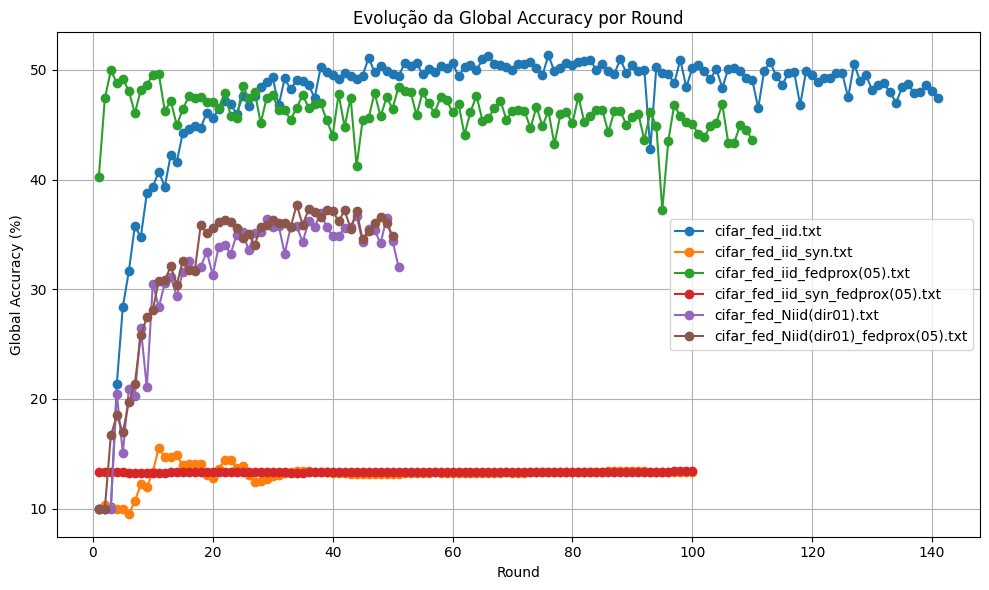

In [ ]:
plot_accuracy(["cifar_fed_iid.txt", "cifar_fed_iid_syn.txt", "cifar_fed_iid_fedprox(05).txt", "cifar_fed_iid_syn_fedprox(05).txt", "cifar_fed_Niid(dir01).txt", "cifar_fed_Niid(dir01)_fedprox(05).txt"])